# What is the hydrological complexity of the UK?

TODO: relative to the skill of the persistence/climatology scores

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Load in driving data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Check runs

In [7]:
run_dir = (data_dir / "runs/complexity")

list(run_dir.iterdir())

[PosixPath('/cats/datastore/data/runs/complexity/hs_008_0303_181518'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_128_0303_181520'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_032_0303_181522'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_004_0303_181524'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_016_0403_082704'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_256_0403_082706'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_064_0403_155703'),
 PosixPath('/cats/datastore/data/runs/complexity/all_results.nc'),
 PosixPath('/cats/datastore/data/runs/complexity/all_errors.pkl')]

In [8]:
all_preds = xr.open_dataset(run_dir / "all_results.nc")

In [9]:
from scripts.drafts.io_results import members_from_coords_to_variables

all_preds = members_from_coords_to_variables(all_preds)

In [10]:
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict

filepath = run_dir / "all_errors.pkl"

if filepath.exists():
    all_errors = pickle.load(filepath.open("rb"))
else:
    all_errors = calculate_all_data_errors(all_preds, decompose_kge=True, yilmaz_errors=True)
    with filepath.open("wb") as fp:
        pickle.dump(all_errors, fp)

In [11]:
all_metrics = get_metric_dataframes_from_output_dict(all_errors)
metrics_xr = xr.Dataset(all_metrics).rename({"dim_1": "model"})

experiment_names = [m for m in metrics_xr.model.values]
hidden_sizes = [int(m.split("_")[1]) for m in metrics_xr.model.values]
metrics_xr["model"] = hidden_sizes
metrics_xr = metrics_xr.rename({"model": "hidden_size"})

metrics_xr

<xarray.Dataset>
Dimensions:                 (hidden_size: 7, station_id: 667)
Coordinates:
  * station_id              (station_id) int64 10002 10003 1001 ... 96004 97002
  * hidden_size             (hidden_size) int64 4 8 16 32 64 128 256
Data variables:
    sqrt_variability_ratio  (station_id, hidden_size) float64 0.9382 ... 0.9542
    inv_variability_ratio   (station_id, hidden_size) float64 2.323 ... 0.6546
    variability_ratio       (station_id, hidden_size) float64 0.7484 ... 0.8797
    sqrt_correlation        (station_id, hidden_size) float64 0.9081 ... 0.954
    inv_correlation         (station_id, hidden_size) float64 0.8153 ... 0.8678
    sqrt_bias_ratio         (station_id, hidden_size) float64 0.8535 ... 0.9855
    inv_bias_ratio          (station_id, hidden_size) float64 1.638 ... 0.9302
    abs_pct_bias            (station_id, hidden_size) float64 25.09 ... 4.227
    correlation             (station_id, hidden_size) float64 0.8934 ... 0.9293
    bias_error              (station_id, hidden_size) float64 -0.2509 ... -0....
    bias_ratio              (station_id, hidden_size) float64 0.7491 ... 0.9577
    std_error               (station_id, hidden_size) float64 -0.2516 ... -0....
    mam30_ape               (station_id, hidden_size) float32 48.18 ... 23.73
    sqrt_kge                (station_id, hidden_size) float64 0.8163 ... 0.9335
    log_nse                 (station_id, hidden_size) float64 0.4419 ... 0.9134
    inv_kge                 (station_id, hidden_size) float64 -0.4804 ... 0.6236
    member                  (station_id, hidden_size) object 'hs_004_0303_181...
    pbias                   (station_id, hidden_size) float64 25.09 ... 4.227
    bias                    (station_id, hidden_size) float64 -25.09 ... -4.227
    mape                    (station_id, hidden_size) float64 32.27 ... 23.71
    rmse                    (station_id, hidden_size) float64 0.8041 ... 0.9412
    nse                     (station_id, hidden_size) float64 0.7134 ... 0.8599
    kge                     (station_id, hidden_size) float64 0.6291 ... 0.8542
    mse                     (station_id, hidden_size) float64 0.6466 ... 0.8859
    fms                     (station_id, hidden_size) float64 18.58 ... 8.37
    flv                     (station_id, hidden_size) float64 -96.06 ... 49.31
    fhv                     (station_id, hidden_size) float64 -28.66 ... -11.5

# Overall complexity required?

In [12]:
hidden_sizes

[4, 8, 16, 32, 64, 128, 256]

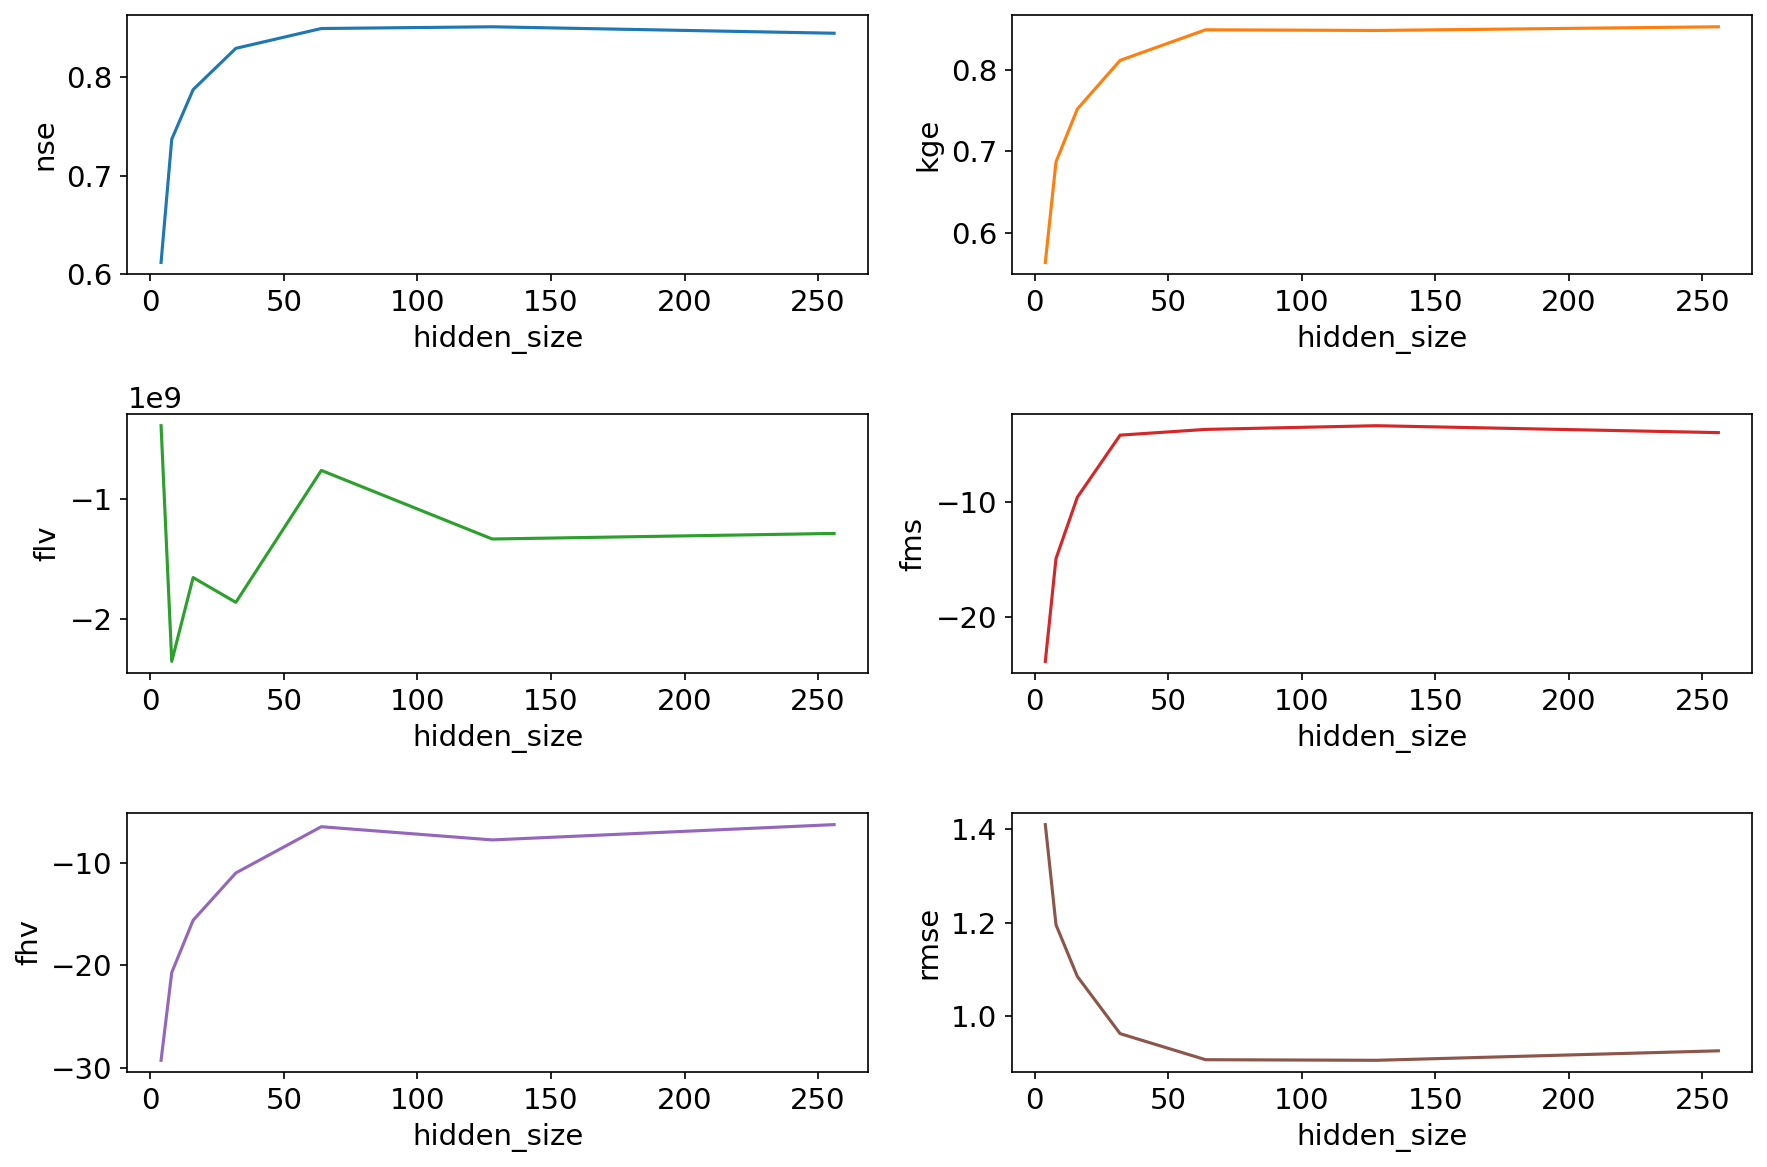

In [13]:
f, axs = plt.subplots(3, 2, figsize=(12, 8))
metrics = ["nse", "kge", "flv", "fms", "fhv", "rmse"]
for ix, metric in enumerate(metrics):
    ax = axs[np.unravel_index(ix, (3, 2))]
    metrics_xr[metric].mean(dim="station_id").plot(ax=ax, color=f"C{ix}")
    
plt.tight_layout()

# CDFs 

In [14]:
from scripts.drafts.plots import plot_cdf
scale = 0.6
FIGSIZE = (12*scale, 8*scale)

clipping_lookup = {
    "nse": (0, 1.),
    "kge": (0, 1),
    "correlation": (0.5, 1),
    "bias_ratio": (0, 1.5),
    "variability_ratio": (0, 1.5),
    "bias_error": (-0.5, 0.5),
    "std_error": (-0.5, 0.5),
    "bias_error_pct": (-50, 50),
    "std_error_pct": (-50, 50),
    "flv": (-100, 100), 
    "fms": (-100, 100), 
    "fhv": (-100, 100), 
}

colors = sns.color_palette("viridis", 7)
kwargs_dict = {
    'hs_004_0303_181524': {"color":colors[0], "alpha": 0.7},
    'hs_008_0303_181518': {"color":colors[1], "alpha": 0.7},
    'hs_016_0403_082704': {"color":colors[2], "alpha": 0.7},
    'hs_032_0303_181522': {"color":colors[3], "alpha": 0.7},
    'hs_064_0403_155703': {"color":colors[4], "alpha": 0.7},
    'hs_128_0303_181520': {"color":colors[5], "alpha": 0.7},
    'hs_256_0403_082706': {"color":colors[6], "alpha": 0.7},

}

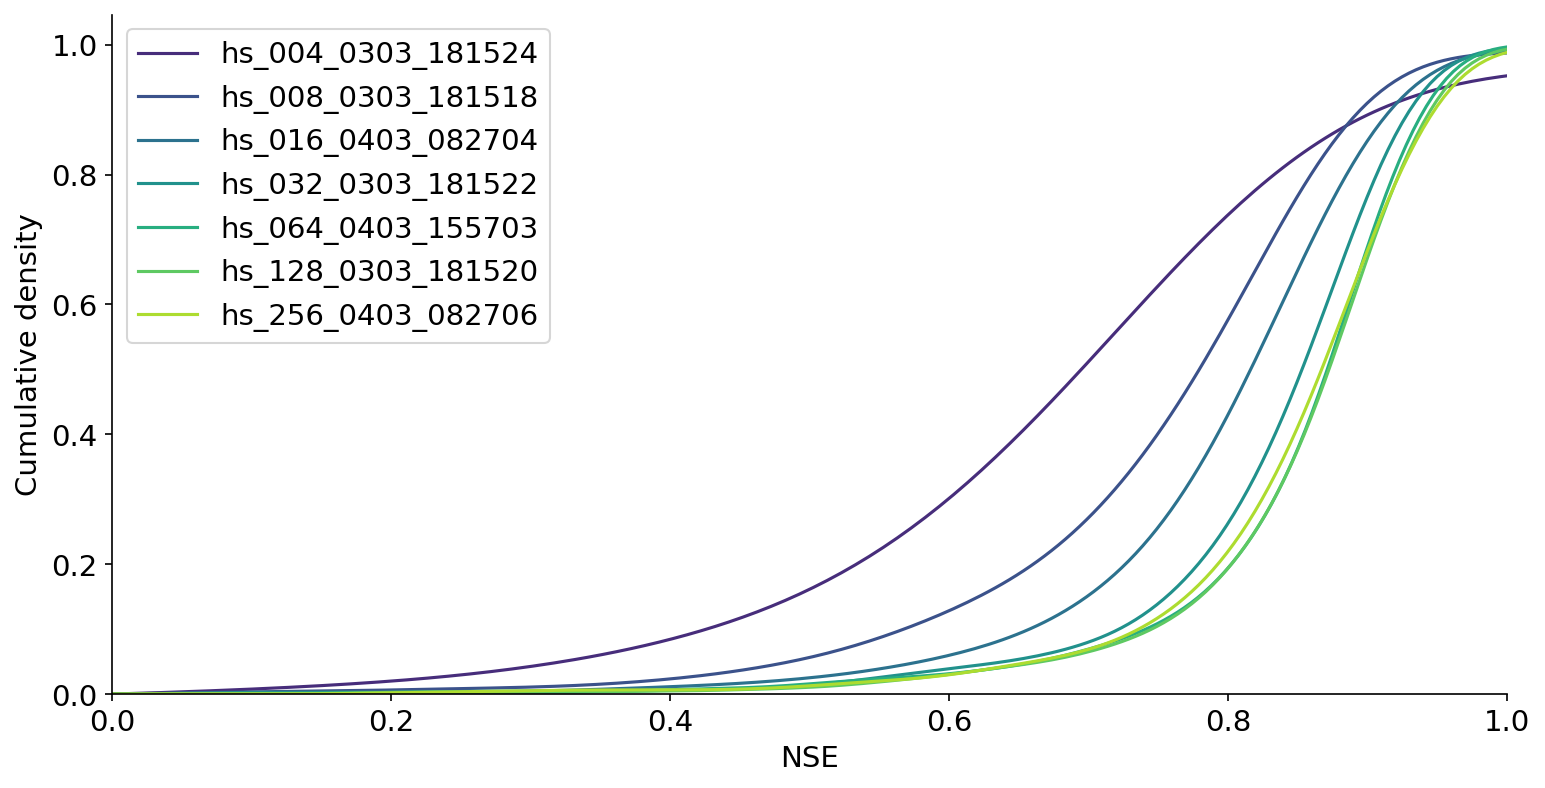

In [15]:
scale = 1.
f, ax = plt.subplots(figsize=(12*scale, 6*scale))
metrics = all_metrics["nse"].drop([c for c in  all_metrics["nse"].columns if "climatology" in c or "persistence" in c], axis=1)
plot_cdf(metrics, metric="NSE", title="", ax=ax, clip=(0, 1), median=True, summary_line=False, kwargs_dict=kwargs_dict);

# Geospatial Patterns

In [16]:
import geopandas as gpd

# catchment shapefiles
shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}
geo_df.to_crs(epsg=4326)

# Station Gauge lat-lon points (already in EPSG:4326)
d = static[["gauge_lat", "gauge_lon"]].to_dataframe()
points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
points.name = "geometry"

In [17]:
assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"

world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [18]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
names = static["gauge_name"].to_dataframe()
poly = geo_df.set_index("ID").loc[catchment_ids].join(names).to_crs(epsg=4326)
all_poly = geo_df.set_index("ID").join(names).to_crs(epsg=4326)
pts = gpd.GeoDataFrame(points.loc[catchment_ids]).join(names)
all_points = gpd.GeoDataFrame(points).join(names)

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import Any, Optional, Dict


markersize = 10
# "scheme": "quantiles" if quantiles else None
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "nse": {"vmin": 0.7, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # nse  8
    "log_nse": {"vmin": 0.6, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # log nse  8
    "kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'cividis_r', "markersize": markersize},    # kge   
    "inv_kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},    # inv kge   
    "mape": {"vmin": 0, "vmax": None, 'cmap': 'plasma_r', "markersize": markersize},    # inv kge   
    "bias": {"vmin": -20, "vmax": 20, 'cmap': 'RdBu', "markersize": markersize},    # bias  
    "abs_pct_bias": {"vmin": 0, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},    # abs_pct_bias
    "mam30_ape": {"vmin": 0, "vmax": 50, 'cmap': 'RdBu', "markersize": markersize},    # mam30_ape  
    "correlation":{"vmin": 0.85, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},
    "bias_ratio":{"vmin": 0.8, "vmax": 1.2, 'cmap': 'RdBu', "markersize": markersize},  
    "variability_ratio":{"vmin": 0.8, "vmax": 1.2, 'cmap': 'RdBu', "markersize": markersize},
    "bias_error":{"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},  
    "std_error":{"vmin": -0.2, "vmax": 0.2, 'cmap': 'RdBu', "markersize": markersize},
    "flv":{"vmin": -100, "vmax": 100, 'cmap': 'RdBu', "markersize": markersize},
    "fms":{"vmin": -25, "vmax": 25, 'cmap': 'RdBu', "markersize": markersize},
    "fhv":{"vmin": -25, "vmax": 25, 'cmap': 'RdBu', "markersize": markersize},
}

from typing import List, Any 


def create_geospatial_data(df: pd.DataFrame) -> gpd.GeoDataFrame:
    return gpd.GeoDataFrame(df.join(points), crs="epsg:4326")


def _add_colorbar(ax: Any, kwargs: Dict[str, float], title: str = ""):
    assert all(np.isin(["cmap", "vmin", "vmax"], [k for k in kwargs.keys()]))
    # get the legend / colorbar
    fig = ax.get_figure()
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap=kwargs["cmap"], norm=plt.Normalize(vmin=kwargs["vmin"], vmax=kwargs["vmax"]))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    # cbar.set_label('title', rotation=270)


def _plot_geospatial(metric_data: gpd.GeoDataFrame, column: str, ax: Any, legend: bool = True, cax: Optional[Any] = None, kwargs: Dict = {}):
    # plot the chloropleth
    metric_data.to_crs(epsg=4326).plot(column, ax=ax, cax=cax, legend=legend, **kwargs);

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)

    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])
    ax.axis('off')
    return ax

def plot_geospatial_data_per_model(model_data, model: str, metrics: List[str] = ["nse", "bias", "kge"]):
    assert all(np.isin(metrics, model_data.columns))
    
    n_metrics = len(metrics)
    if n_metrics == 3:
        fig, axs = plt.subplots(1, 3, figsize=(5*n_metrics, 8))
        shape = (1, 3)
    else:
        nrows = (n_metrics // 2) + (n_metrics % 2)
        fig, axs = plt.subplots(nrows, 2, figsize=(5*2, 8*nrows))
        shape = (nrows, 2)
        
    for ix, metric in enumerate(metrics):
        ax = axs[np.unravel_index(ix, shape)]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        ax = _plot_geospatial(model_data, column=metric, ax=ax, cax=cax, kwargs=opts[metric])
        ax.set_title(metric.upper())
        
    fig.tight_layout()
#     fig.tight_layout(rect=[0, 0.03, 1, 0.965]);
#     fig.suptitle(f"{model} Model Error", size=14);


def plot_geospatial_data_per_metric(metric_data, metric: str, models: List[str] = ["LSTM", "EALSTM", "SACRAMENTO"], legend: bool = False, kwargs: Optional[Dict[str, Any]] = None):
    assert all(np.isin(models, metric_data.columns))
    n_models = len(models)
    
    scale = 0.6
    fig, axs = plt.subplots(1,  n_models, figsize=(5*n_models*scale, 8*scale))
    shape = (n_models,)

    for ix, model in enumerate(models):
        ax = axs[np.unravel_index(ix, shape)]
        
        if legend:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        else:
            cax = None
        
        # plot the chloropleth
        kwargs = opts[metric] if kwargs is None else kwargs
        ax = _plot_geospatial(metric_data, column=model, ax=ax, kwargs=kwargs, legend=legend, cax=cax)

        ax.set_title(model.upper())
        if not legend:
            pass
    fig.tight_layout()

    
def plot_metric_data_per_season(metric_data, metric="nse", legend: bool = False, kwargs: Optional[Dict[str, Any]] = None):
    seasons = ["DJF", "MAM", "JJA", "SON"]
    assert "season" in metric_data.columns
    assert all(np.isin(seasons, metric_data["season"].unique()))
    n_seasons = len(seasons)
    
    # build the subplot
    scale = 0.6
    fig, axs = plt.subplots(1,  n_seasons, figsize=(5*n_seasons*scale, 8*scale))
    shape = (n_seasons,)

    for ix, season in enumerate(seasons):
        ax = axs[np.unravel_index(ix, shape)]
        
        if legend:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        else:
            cax = None
        # plot the chloropleth
        kwargs = opts[metric] if kwargs is None else kwargs
        # subset the seasonal points
        plot_data = metric_data.loc[metric_data["season"] == season]
        ax = _plot_geospatial(plot_data, column=metric, ax=ax, kwargs=kwargs, legend=legend, cax=cax)

        ax.set_title(season.upper())
    
    fig.tight_layout()


    return

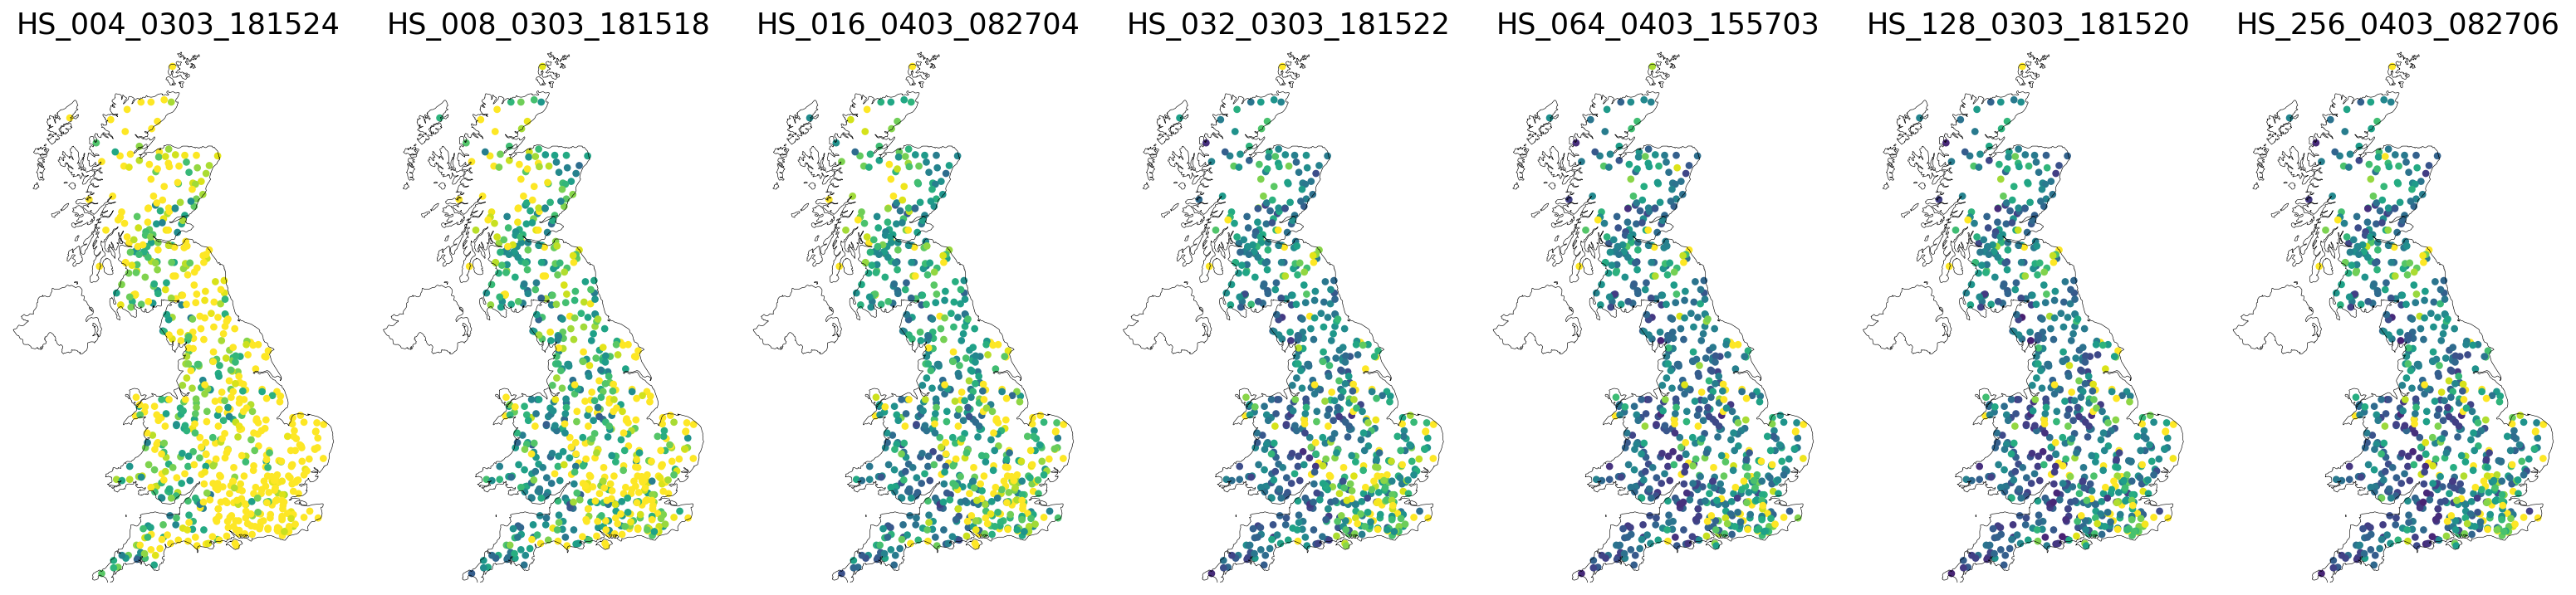

In [20]:
plot_geospatial_data_per_metric(create_geospatial_data(all_metrics["nse"]), metric="nse", models=experiment_names)

# Regional Performances

In [21]:
lakes = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_Lakes/UK_Lakes.shp").to_crs(epsg=4326)
hydro_regions = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "UK_hydroclimate_regions_Harrigan_et_al_2018/UK_Hydro_Regions_ESP_HESS.shp").to_crs(epsg=4326)
hydro_regions = hydro_regions.loc[~np.isin(hydro_regions["NAME"], ["Northern Ireland", "Republic of Ireland"])]
aquifers = gpd.read_file(data_dir / "RUNOFF/gis_data_Tommy" / "Aquifers/Uk_HydroGeology_Simplified.shp").to_crs(epsg=4326)

In [22]:
region_abbrs = {
    'Western Scotland': "WS",
    'Eastern Scotland': "ES",
    'North-east England': "NEE",
    'Severn-Trent': "ST",
    'Anglian': "ANG",
    'Southern England': "SE",
    'South-west England & South Wales': "SWESW",
    'North-west England & North Wales (NWENW)': "NWENW",
}

def get_region_station_within(stations: gpd.GeoDataFrame, hydro_regions: gpd.GeoDataFrame):
    # find the region that a station belongs WITHIN
    # create a list of strings/nans for each station 
    region_dict = {}
    for region, geom in zip(hydro_regions["NAME"], hydro_regions["geometry"]):
        isin_region = ([p.within(geom) for p in stations])
        region_dict[region] = [(region if item else np.nan) for item in isin_region]

    region_cols = pd.DataFrame(region_dict)

    # copy non-null values from the right column into the left and select left
    # https://stackoverflow.com/a/49908660
    regions_list = (region_cols.bfill(axis=1).iloc[:, 0]).rename("region")
    regions_list.index = points.index

    return regions_list

In [23]:
regions_list = get_region_station_within(points, hydro_regions)
all_points = gpd.GeoDataFrame(points).join(names).join(regions_list)
hydro_regions

region_gdf = create_geospatial_data(regions_list.to_frame())

In [24]:
from typing import List, Dict, Tuple

def get_region_and_UK_wide_metric(df: pd.DataFrame, agg: str = "median", models: List[str] = ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',]) -> pd.DataFrame:
#     assert all(np.isin(["region", "LSTM"], df.columns))
    if agg == "median":
        # Median in each region
        med_region = df.groupby("region").median()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.median()[models].values, med_region.values])

    elif agg == "mean":
        # Mean in each region
        med_region = df.groupby("region").mean()[models]
        med_region.values.shape

        # Append Whole of UK Median (as a region)
        med_values = np.vstack([df.mean()[models].values, med_region.values])
    else:
        assert False
        
    region = ["UK"] + [region_abbrs[l] for l in med_region.index.values]
    columns = med_region.columns
    med_region = pd.DataFrame(med_values, columns=columns, index=region)
    return med_region


def plot_matrix_of_each_region_and_model(
    df: pd.DataFrame,
    agg: str = "median",
    models: List[str] =  ['TOPMODEL', 'ARNOVIC', 'PRMS', 'SACRAMENTO', 'EALSTM', 'LSTM',],
    kwargs: Dict = {"cmap": "blues"}
):
    assert all(np.isin(["region", "region_abbr"], df.columns)), f"Expect [region region_abbr] to be in {df.columns}"
    assert agg in ["mean", "median"], "Expect agg to be one of median, mean"
    med_region = get_region_and_UK_wide_metric(df, agg=agg, models=models)

    # https://stackoverflow.com/a/40890587
    fig, ax = plt.subplots(figsize=(12, 8))

    intersection_matrix = med_region.values

    ax.imshow(intersection_matrix.T, **kwargs)

    for region_ix in range(intersection_matrix.shape[0]):
        for model_ix in range(intersection_matrix.shape[1]):
            c = intersection_matrix[region_ix, model_ix]
            ax.text(region_ix, model_ix, f"{c:.2f}", va='center', ha='center')

    ax.set_ylabel("Model")
    ax.set_xlabel("Region")
    ax.set_xticklabels([''] + list(med_region.index))
    ax.set_yticklabels([''] + list(med_region.columns))
    
    return ax

Text(0.5, 1.0, 'Median UK and Regional NSE')

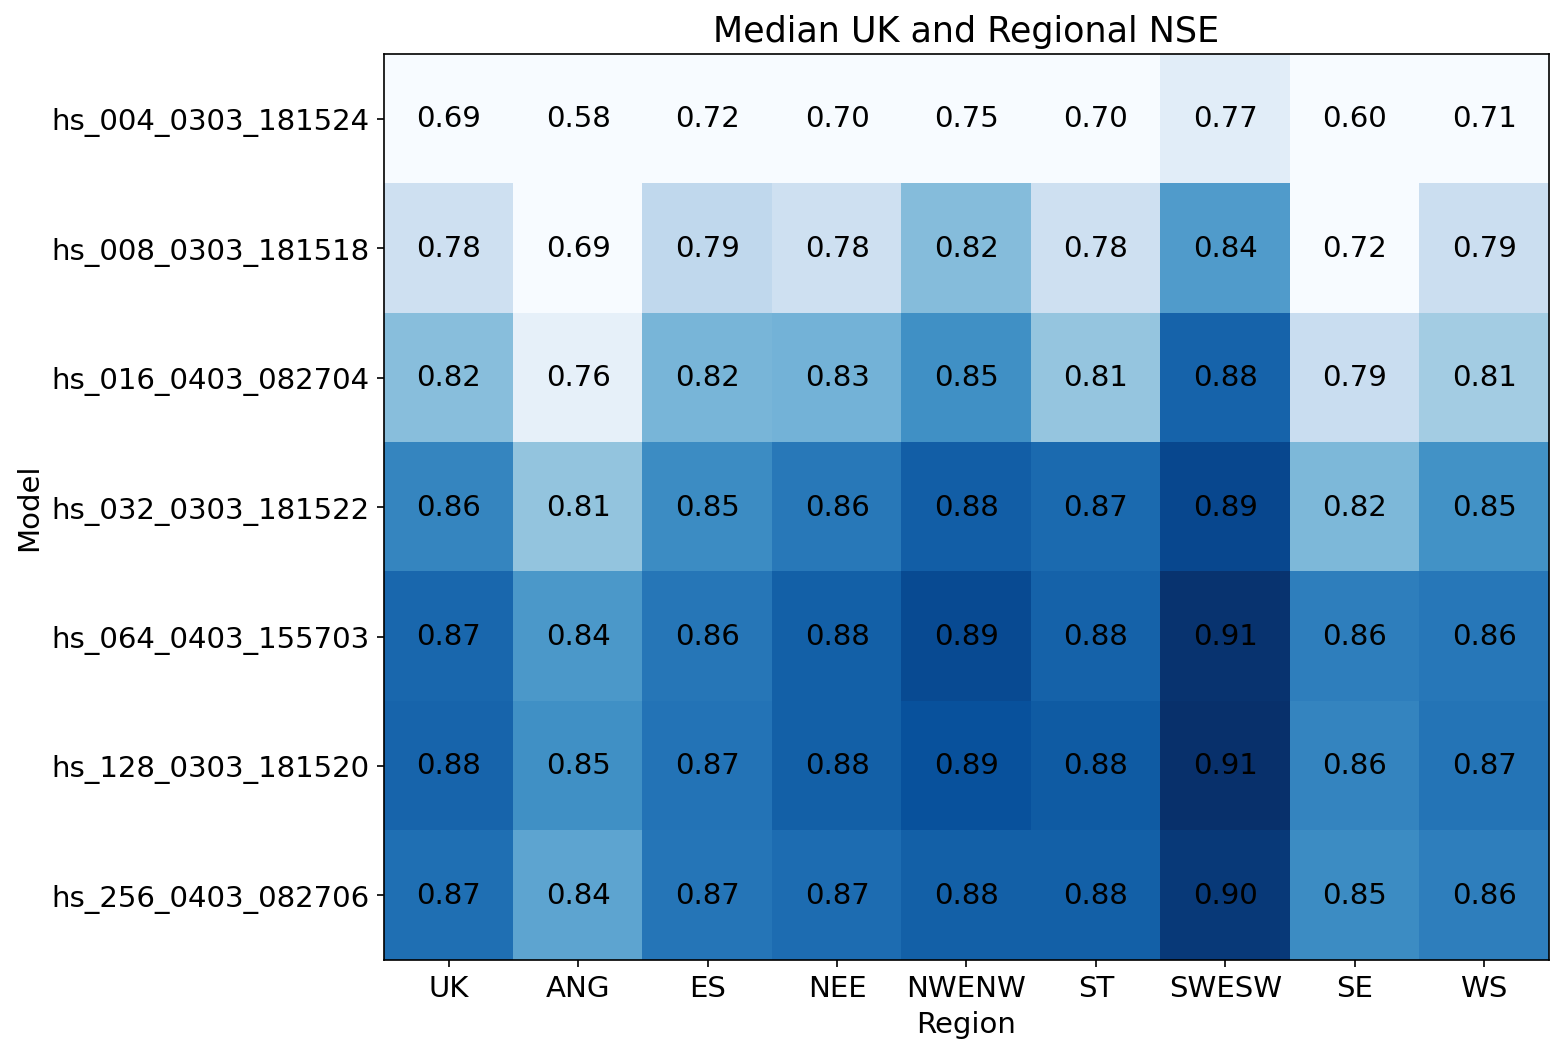

In [25]:
skill_score = False
metric = "nse"

vmin = 0.75
vmax = None
cmap = "Blues"
agg = "median"

# select table of metrics (skill-score or raw)
if skill_score:
    df = skill_scores["climatology_doy"][metric].join(regions_list)
else:
    df = all_metrics[metric].join(regions_list)

df["region_abbr"] = df["region"].map(region_abbrs)

plot_matrix_of_each_region_and_model(df, agg=agg, kwargs={"vmin": vmin, "vmax": vmax, "cmap": cmap}, models=experiment_names)
ax = plt.gca()
ax.set_title(f"{agg.capitalize()} UK and Regional {metric.upper()}{'SS' if skill_score else ''}")

# Load the models and calculate the number of parameters

In [26]:
run_dir = (data_dir / "runs/complexity")

list(run_dir.glob("*/model*30.pt"))

[PosixPath('/cats/datastore/data/runs/complexity/hs_008_0303_181518/model_epoch030.pt'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_128_0303_181520/model_epoch030.pt'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_032_0303_181522/model_epoch030.pt'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_004_0303_181524/model_epoch030.pt'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_016_0403_082704/model_epoch030.pt'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_256_0403_082706/model_epoch030.pt'),
 PosixPath('/cats/datastore/data/runs/complexity/hs_064_0403_155703/model_epoch030.pt')]

In [27]:
# model_paths = sorted(list(run_dir.glob("*/model*30.pt")))
# hidden_sizes = [int(mp.parents[0].name.split("hs_")[-1].split("_")[0]) for mp in model_paths]

In [28]:
from scripts.drafts.cell_state_extract import (load_config_file, load_ealstm, load_lstm, load_normalised_cs_data, normalize_xr_by_basin)
from scripts.drafts.gb_sm_data import (read_gb_sm_data)

In [29]:
complexity_run_dirs = [d for d in (data_dir / "runs/complexity").glob("hs_*")]
complexity_run_dirs = sorted(complexity_run_dirs)
complexity_configs = [load_config_file(d) for d in complexity_run_dirs]
complexity_models = [load_lstm(c) for c in complexity_configs]

In [30]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.1e}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [31]:
m = complexity_models[0]
[np.product(p.shape) for p in list(m.parameters()) if p.requires_grad]

[400, 64, 16, 16, 4, 1]

In [32]:
[p.shape for p in list(complexity_models[1].parameters()) if p.requires_grad]

[torch.Size([32, 25]),
 torch.Size([32, 8]),
 torch.Size([32]),
 torch.Size([32]),
 torch.Size([1, 8]),
 torch.Size([1])]

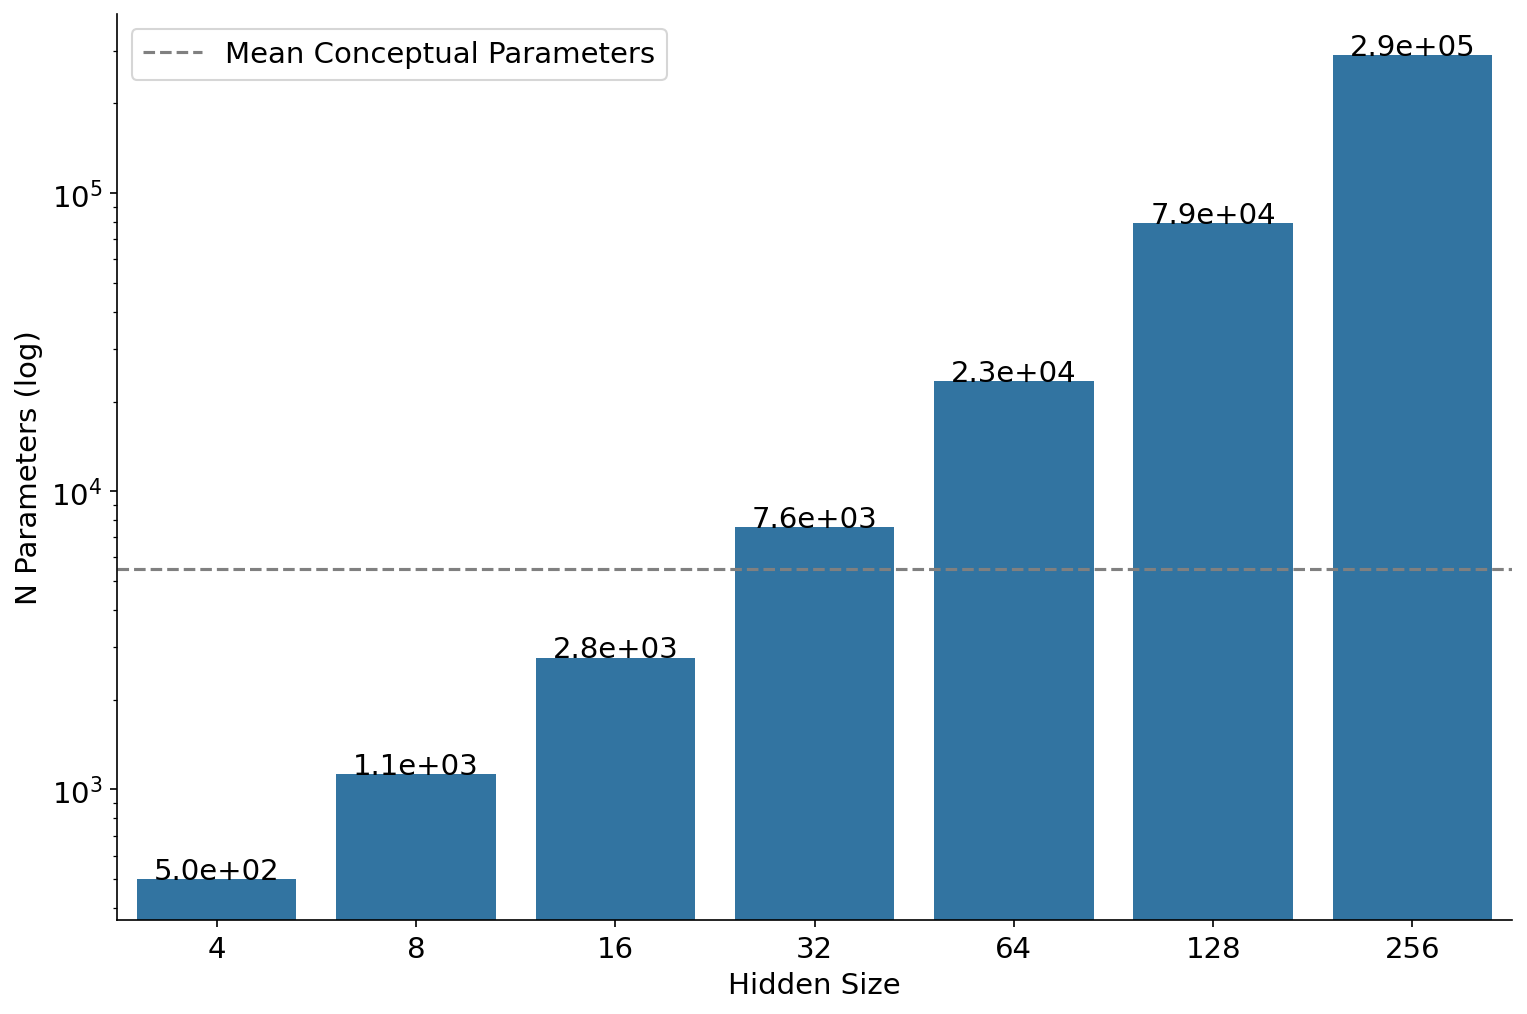

In [33]:
def count_parameters(model):
    return sum(np.product(p.shape) for p in model.parameters() if p.requires_grad)

x = hidden_sizes
y = [count_parameters(m) for m in complexity_models]

f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x, y, color="C0")
show_values_on_bars(ax)
plt.yscale("log")
ax.set_xlabel("Hidden Size")
ax.set_ylabel("N Parameters (log)")
ax.axhline(5500, label="Mean Conceptual Parameters", ls="--", color="grey")
plt.legend()

sns.despine()

In [34]:
y

[501, 1129, 2769, 7585, 23361, 79489, 290049]

In [35]:
c = complexity_configs[0]

In [36]:
print([ll for ll in dir(c) if "attr" in ll])

len(c.dynamic_inputs) + len(c.camels_attributes)

['__delattr__', '__getattribute__', '__setattr__', 'camels_attributes', 'hydroatlas_attributes']


25

# Abilty to reproduce signatures

In [37]:
%autoreload 2

import sys
sys.path.append("/home/tommy/neuralhydrology")

In [38]:
from neuralhydrology.evaluation.signatures import calculate_all_signatures, calculate_signatures, get_available_signatures



obs = all_preds["obs"]
sim = all_preds["hs_004_0303_181524"]
pcp = ds["precipitation"].sel(time=sim.time, station_id=sim.station_id)
station = int(sim.isel(station_id=0).station_id.values)

In [39]:
lookup = {
    hs: variable
    for hs, variable in zip([4, 8, 16, 32, 64, 128, 256], ['hs_004_0303_181524', 'hs_008_0303_181518', 'hs_016_0403_082704', 'hs_032_0303_181522', 'hs_064_0403_155703', 'hs_128_0303_181520', 'hs_256_0403_082706'])
}

signatures = [s for s in get_available_signatures() if s not in ["stream_elas", "runoff_ratio"]]

In [40]:
def calculate_signatures_tommy(discharge: xr.DataArray, precip: xr.DataArray, signatures: Optional[List[str]] = None) -> pd.DataFrame:
    
    if signatures is None:
        signatures = [s for s in get_available_signatures()]
        
    all_sigs = []
    pbar = tqdm(discharge.station_id.values, desc=f"Calculating Signatures for {discharge.name}: ")
    for station in pbar:
        pbar.set_postfix_str(str(station))
        sigs = calculate_signatures(
            da=discharge.sel(station_id=station), prcp=precip.sel(station_id=station), datetime_coord="time", signatures=signatures
        )
        sigs = pd.DataFrame(sigs, index=[station])
        all_sigs.append(sigs)
    signature_df = pd.concat(all_sigs).reset_index().rename({"index": "station_id"}, axis=1).set_index("station_id")
    return signature_df

In [41]:
if not (data_dir / "CONCEPT/all_signatures.nc").exists():
    all_signatures = []
    for hs in lookup.keys():
        variable = lookup[hs]
        sim = all_preds[variable]
        pcp = ds["precipitation"].sel(time=sim.time, station_id=sim.station_id)

        signature_df = calculate_signatures_tommy(discharge=sim, precip=pcp, signatures=signatures)
        signature_df["model"] = variable
        signature_df = signature_df.reset_index().set_index(["station_id", "model"])
        all_signatures.append(signature_df)        
    
    # append the 
    obs = all_preds["obs"]
    pcp = ds["precipitation"].sel(time=obs.time, station_id=sim.station_id)
    obs_signatures = calculate_signatures_tommy(discharge=obs, precip=pcp, signatures=signatures)
    obs_signatures["model"] = "obs"
    obs_signatures = obs_signatures.reset_index().set_index(["station_id", "model"])

    all_signatures.append(obs_signatures)

    # merge into one xr.Dataset
    all_sigs = xr.merge([d.to_xarray() for d in all_signatures])
    all_sigs.to_netcdf(data_dir / "CONCEPT/all_signatures.nc")

else:
    all_sigs = xr.open_dataset(data_dir / "CONCEPT/all_signatures.nc")

In [42]:
all_sigs

<xarray.Dataset>
Dimensions:         (model: 8, station_id: 669)
Coordinates:
  * model           (model) object 'hs_004_0303_181524' ... 'obs'
  * station_id      (station_id) int64 1001 2001 2002 ... 102001 106001 107001
Data variables:
    high_q_freq     (station_id, model) float64 ...
    high_q_dur      (station_id, model) float64 ...
    low_q_freq      (station_id, model) float64 ...
    low_q_dur       (station_id, model) float64 ...
    zero_q_freq     (station_id, model) float64 ...
    q95             (station_id, model) float64 ...
    q5              (station_id, model) float64 ...
    q_mean          (station_id, model) float64 ...
    hfd_mean        (station_id, model) float64 ...
    baseflow_index  (station_id, model) float64 ...
    slope_fdc       (station_id, model) float64 ...

### TODO:
- Why do runoff ratio and stream elasticity not work?

```python
variable = list(lookup.values())[0]
signatures = ["stream_elas", "runoff_ratio"]
sim = all_preds[variable]
pcp = ds["precipitation"].sel(time=sim.time, station_id=sim.station_id)

signature_df = calculate_signatures_tommy(discharge=sim, precip=pcp, signatures=signatures)
```

```
Calculating Signatures for hs_004_0303_181524:   0%|          | 0/669 [00:00<?, ?it/s, 10002]
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-53-528e762a4a65> in <module>
      4 pcp = ds["precipitation"].sel(time=sim.time, station_id=sim.station_id)
      5 
----> 6 signature_df = calculate_signatures_tommy(discharge=sim, precip=pcp, signatures=signatures)

<ipython-input-40-bfec9bf491fd> in calculate_signatures_tommy(discharge, precip, signatures)
      9         pbar.set_postfix_str(str(station))
     10         sigs = calculate_signatures(
---> 11             da=discharge.sel(station_id=station), prcp=precip.sel(station_id=station), datetime_coord="time", signatures=signatures
     12         )
     13         sigs = pd.DataFrame(sigs, index=[station])

~/neuralhydrology/neuralhydrology/evaluation/signatures.py in calculate_signatures(da, signatures, datetime_coord, prcp)
    120             values["runoff_ratio"] = runoff_ratio(da, prcp, datetime_coord=datetime_coord)
    121         elif signature == "stream_elas":
--> 122             values["stream_elas"] = stream_elas(da, prcp, datetime_coord=datetime_coord)
    123         else:
    124             ValueError(f"Unknown signatures {signature}")

~/neuralhydrology/neuralhydrology/evaluation/signatures.py in stream_elas(da, prcp, datetime_coord)
    675 
    676     # rename precip coordinate name (to avoid problems with 'index' or 'date')
--> 677     prcp = prcp.rename({list(prcp.coords.keys())[0]: datetime_coord})
    678 
    679     # slice prcp to the same time window as the discharge

/cats/datastore/data/minconda3/envs/ml/lib/python3.7/site-packages/xarray/core/dataarray.py in rename(self, new_name_or_name_dict, **names)
   1689             )
   1690             name_dict = either_dict_or_kwargs(new_name_or_name_dict, names, "rename")
-> 1691             dataset = self._to_temp_dataset().rename(name_dict)
   1692             return self._from_temp_dataset(dataset)
   1693         else:

/cats/datastore/data/minconda3/envs/ml/lib/python3.7/site-packages/xarray/core/dataset.py in rename(self, name_dict, **names)
   3009 
   3010         variables, coord_names, dims, indexes = self._rename_all(
-> 3011             name_dict=name_dict, dims_dict=name_dict
   3012         )
   3013         assert_unique_multiindex_level_names(variables)

/cats/datastore/data/minconda3/envs/ml/lib/python3.7/site-packages/xarray/core/dataset.py in _rename_all(self, name_dict, dims_dict)
   2967 
   2968     def _rename_all(self, name_dict, dims_dict):
-> 2969         variables, coord_names = self._rename_vars(name_dict, dims_dict)
   2970         dims = self._rename_dims(dims_dict)
   2971         indexes = self._rename_indexes(name_dict, dims.keys())

/cats/datastore/data/minconda3/envs/ml/lib/python3.7/site-packages/xarray/core/dataset.py in _rename_vars(self, name_dict, dims_dict)
   2941             name = name_dict.get(k, k)
   2942             if name in variables:
-> 2943                 raise ValueError(f"the new name {name!r} conflicts")
   2944             variables[name] = var
   2945             if k in self._coord_names:

ValueError: the new name 'time' conflicts
```

# Calculate correlations for all signatures

In [43]:
from collections import defaultdict


def calculate_all_signature_correlations(all_sigs: xr.Dataset) -> pd.DataFrame:
    assert all(np.isin(["obs"], list(all_sigs.model.values)))
    obs = all_sigs.sel(model="obs")
    corr_df = defaultdict(list)
    model_names = []

    for model in [v for v in all_sigs.model.values if v != "obs"]:
        comparison = all_sigs.sel(model=model)
        model_names.append(str(comparison.model.values))
        for variable in list(obs.data_vars):
            corr = float(xr.corr(obs[variable], comparison[variable]))
            corr_df[variable].append(corr)


    return pd.DataFrame(corr_df, index=model_names)

In [44]:
corr_df = calculate_all_signature_correlations(all_sigs)
corr_df["hidden_size"] = [int(name.split("_")[1]) for name in corr_df.index]
corr_df = corr_df.dropna(how="all", axis=1)
corr_df

high_q_freq  high_q_dur  low_q_freq  low_q_dur       q95  \
hs_004_0303_181524     0.349871    0.051887    0.375426  -0.112330  0.963586   
hs_008_0303_181518     0.496233    0.226989    0.531301  -0.047854  0.975089   
hs_016_0403_082704     0.644581    0.882308    0.623193  -0.010529  0.984688   
hs_032_0303_181522     0.698025    0.838944    0.769224   0.088234  0.990686   
hs_064_0403_155703     0.810954    0.862875    0.811040   0.188043  0.991513   
hs_128_0303_181520     0.869597    0.973787    0.898450   0.519634  0.992183   
hs_256_0403_082706     0.897499    0.959235    0.905100   0.360549  0.991804   

                          q5    q_mean  hfd_mean  baseflow_index  slope_fdc  \
hs_004_0303_181524  0.725035  0.975324  0.859380        0.696301   0.553152   
hs_008_0303_181518  0.803526  0.980779  0.902666        0.783023   0.592502   
hs_016_0403_082704  0.782445  0.986117  0.926109        0.857286   0.660460   
hs_032_0303_181522  0.890430  0.992876  0.943746        0.922434   0.698073   
hs_064_0403_155703  0.934089  0.994572  0.952354        0.952135   0.748064   
hs_128_0303_181520  0.947150  0.994790  0.962060        0.966355   0.782482   
hs_256_0403_082706  0.950409  0.994527  0.963489        0.969135   0.777438   

                    hidden_size  
hs_004_0303_181524            4  
hs_008_0303_181518            8  
hs_016_0403_082704           16  
hs_032_0303_181522           32  
hs_064_0403_155703           64  
hs_128_0303_181520          128  
hs_256_0403_082706          256

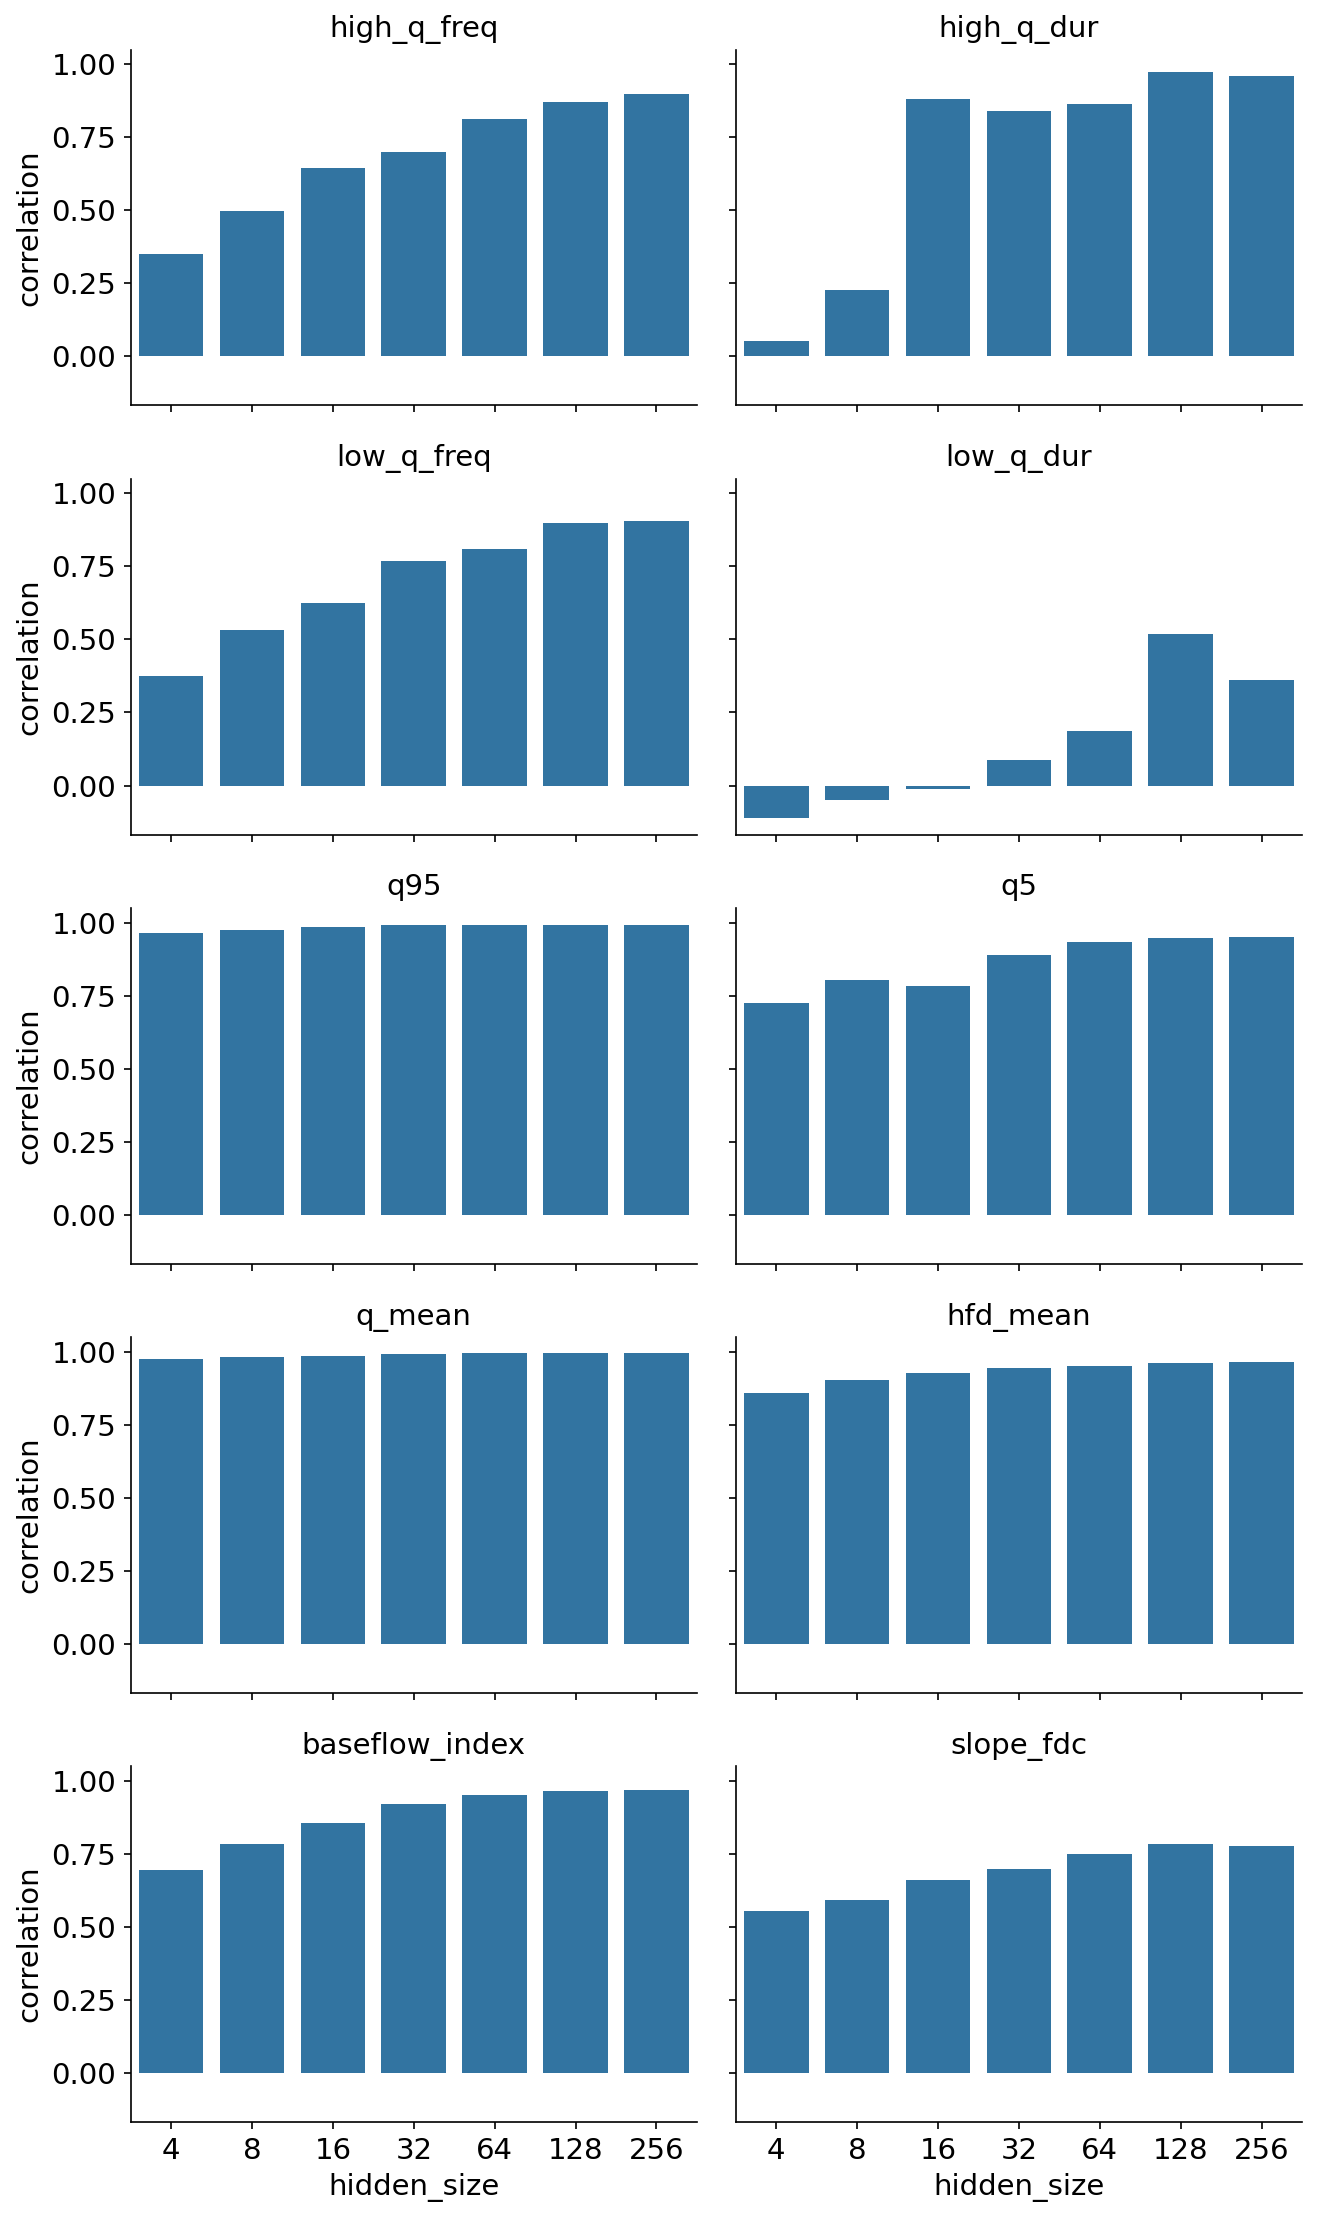

In [45]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable

norm = TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)
cmap = plt.get_cmap('bwr')


def my_bar_plot(x, y, **kwargs):
    plt.bar(height=y, x=x, color=cmap(norm(x)))

# wide to long format
sns_df = corr_df.melt(id_vars=["hidden_size"]).rename({"value": "correlation"}, axis=1)

# wrap the variables as a facetgrid
g = sns.FacetGrid(data=sns_df, col='variable', sharex=True, sharey=True, col_wrap=2, aspect=1.5)
g.map(sns.barplot, 'hidden_size', 'correlation')
g.set_titles(col_template="{col_name}")

# Hydrographs

In [46]:
from scripts.drafts.hydrographs import plot_station_hydrograph, get_hydrological_year, get_all_data_for_basins

In [47]:
def plot_station_hg(all_preds: xr.Dataset, station_id: int, year: str="2007", scale: float = 1.4):
    f, ax = plt.subplots(figsize=(12*scale, 4*scale))
    hydro_year_ts = get_hydrological_year(int(year))
    d = get_all_data_for_basins(all_preds, station_id, columns=list(all_preds.data_vars)).set_index("time")

    plot_station_hydrograph(
        data=d.loc[hydro_year_ts[0] : hydro_year_ts[-1]].reset_index(),
        station_id=station_id,
        static_df=static.to_dataframe(),
        dynamic=ds,
        nse_df=all_metrics["nse"],
        legend_kwargs={"loc": "lower right"},
        ax=ax,
        legend=True,
        nse_in_title=True,
        non_overlap=True,
        original_plot=False,
    )

    plt.tight_layout()

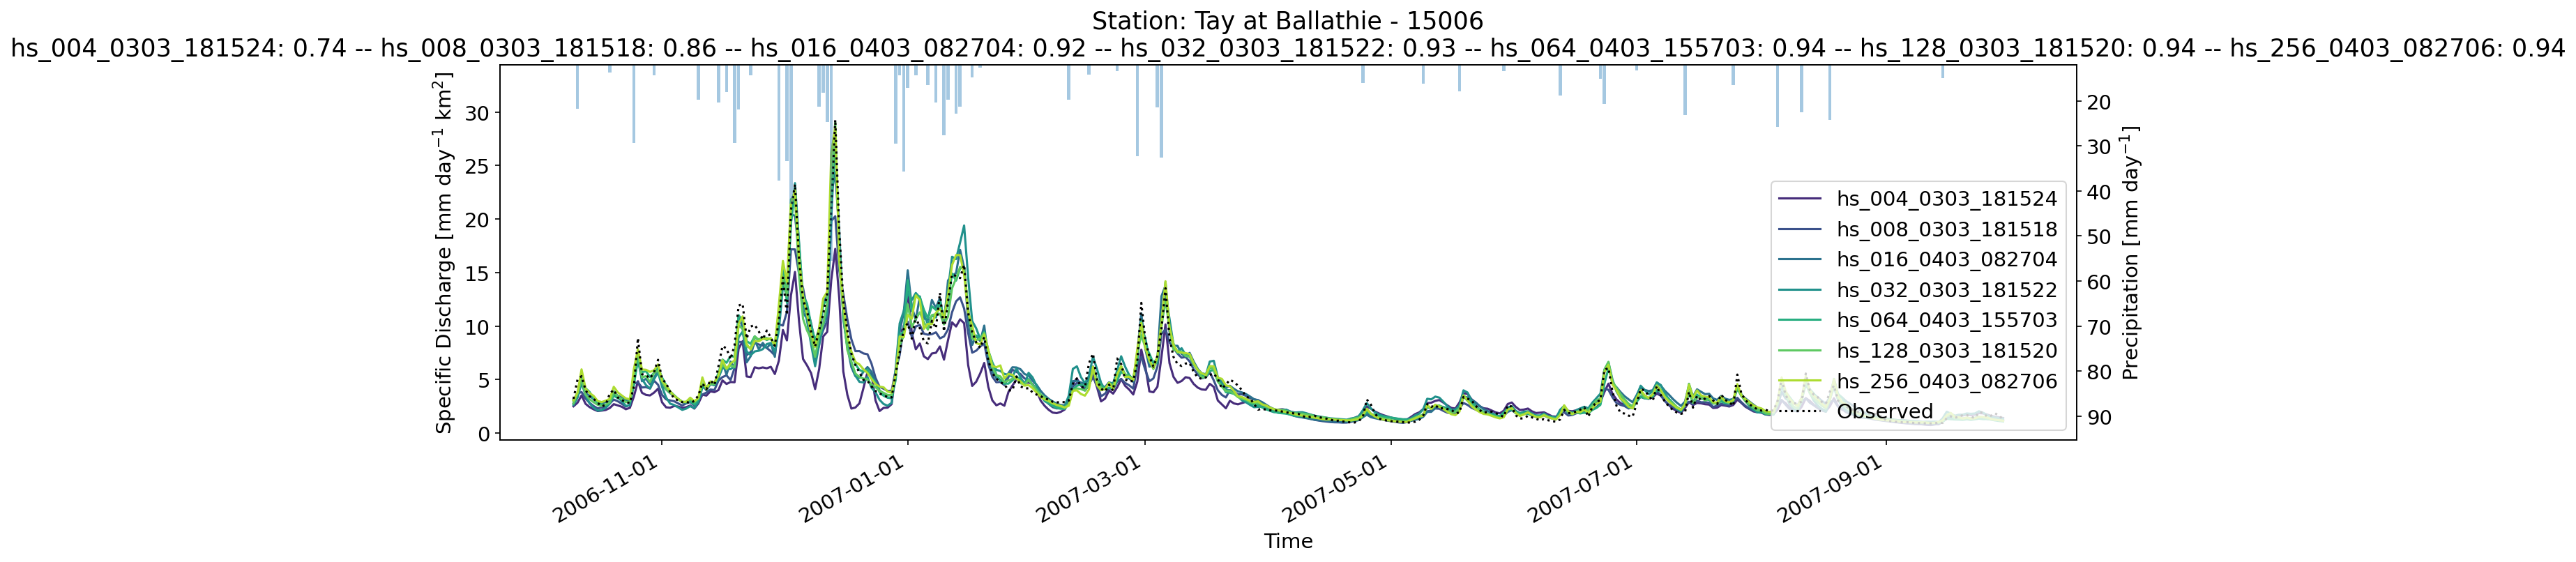

In [48]:
# for hs_model in list(lookup.values()):
#     plot_station_hg(all_preds[[hs_model, "obs"]], 15006)

plot_station_hg(all_preds, 15006)

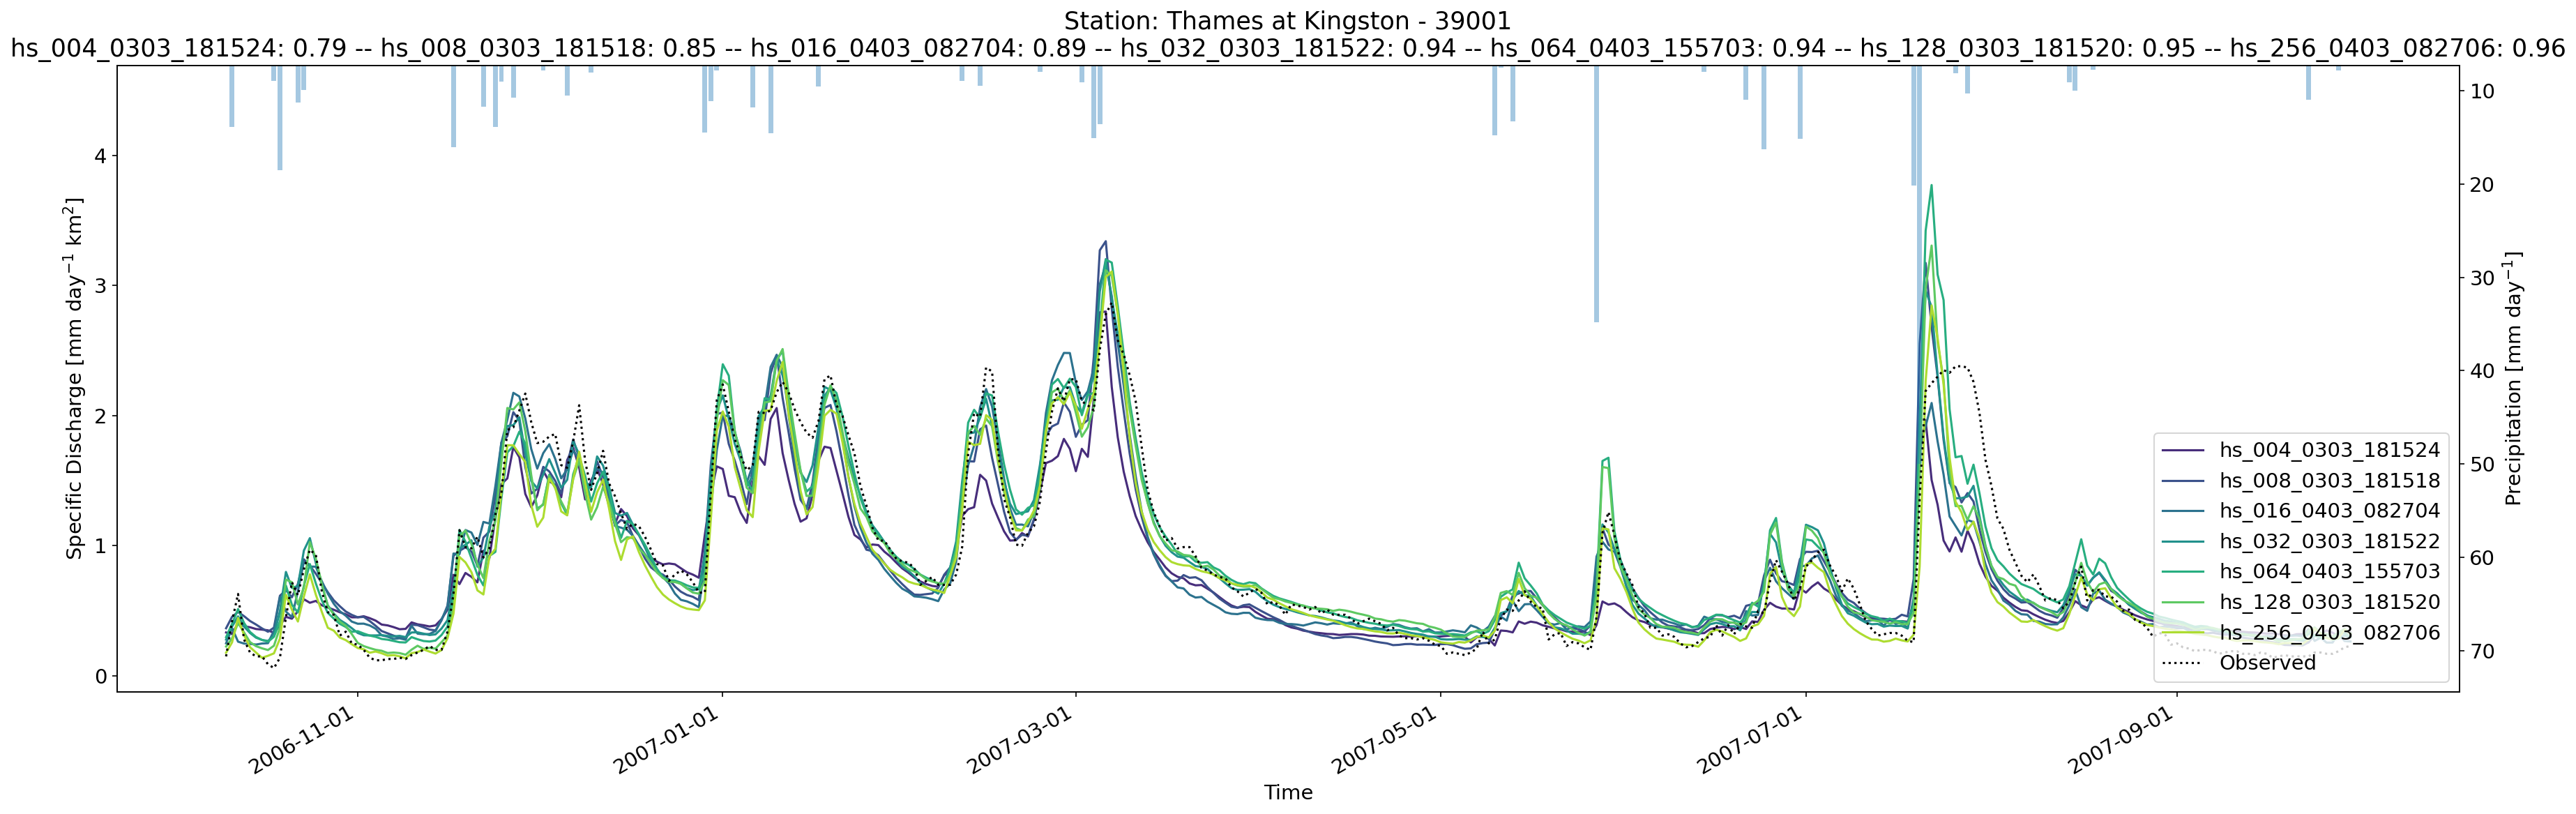

In [49]:
plot_station_hg(all_preds, 39001, scale=2)

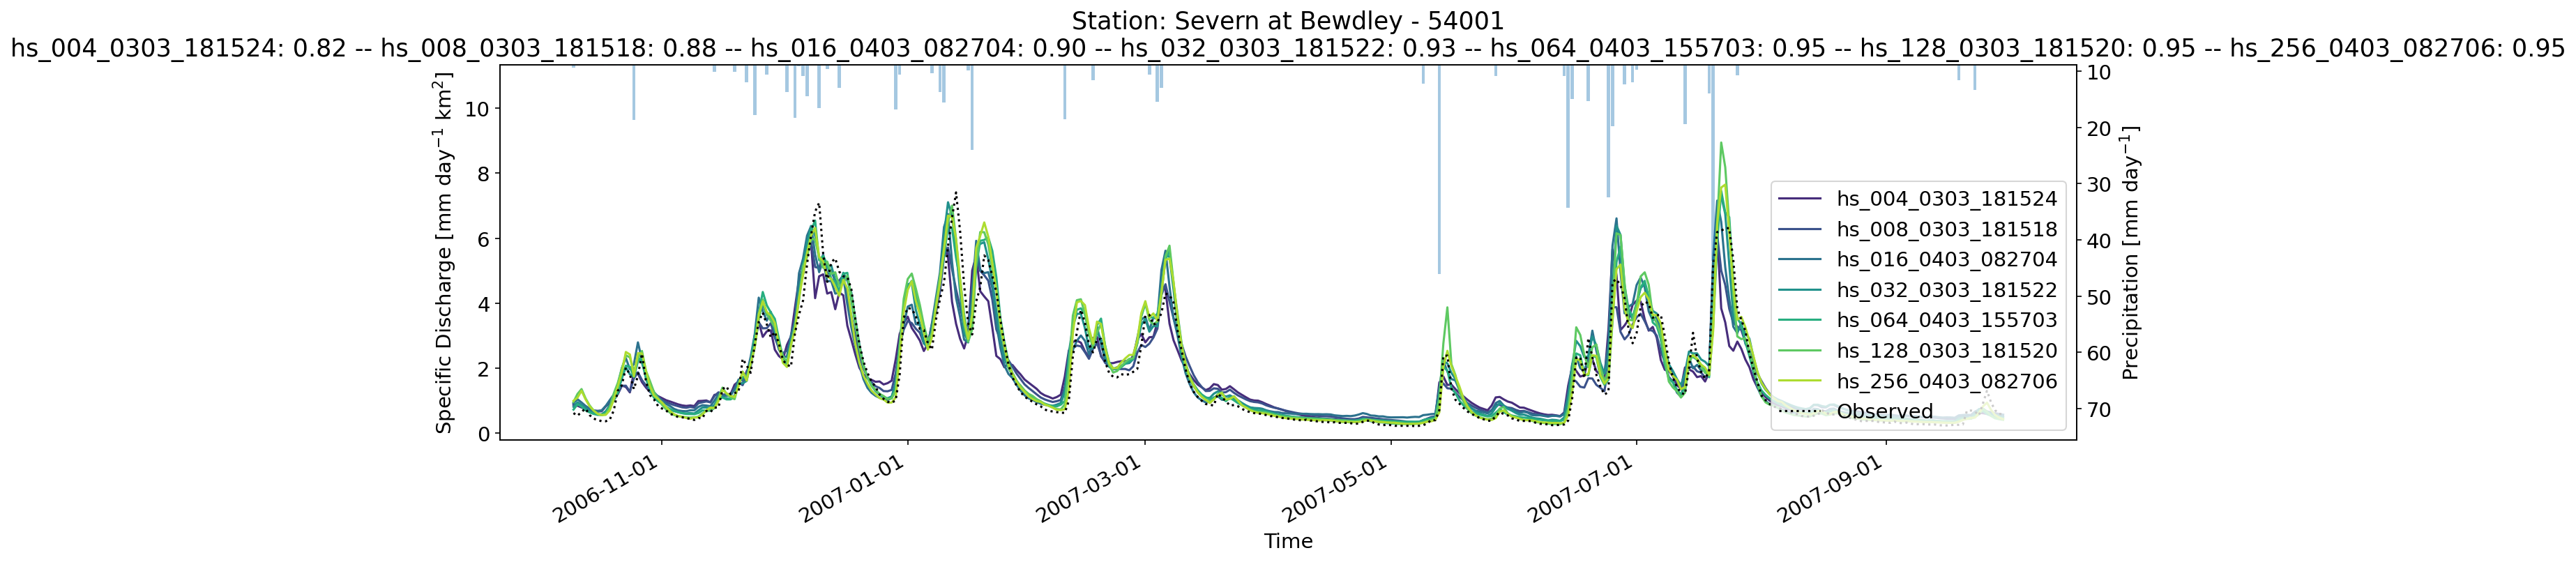

In [50]:
plot_station_hg(all_preds, 54001)

In [51]:
granny_sid = float(static.sel(station_id=["marple" in s.lower() for s in static["gauge_name"].values]).station_id)
# plot_station_hg(all_preds, int(granny_sid), scale=2)

# What is happening in the borderlands region?

In [155]:
border_sids = static.sel(
    station_id=[
        any(xs in c for xs in ["Eye Water", "Blackadder Water", "Whiteadder Water", "Leet Water"]) 
        for c in static["gauge_name"].values
    ]
).station_id.values
print(static.sel(station_id=border_sids)["gauge_name"].values)
print(border_sids)

['Eye Water at Eyemouth Mill' 'Whiteadder Water at Hutton Castle'
 'Leet Water at Coldstream' 'Blackadder Water at Mouth Bridge']
[21016 21022 21023 21027]


In [75]:
metrics_xr.sel(station_id=border_sids)["nse"]

<xarray.DataArray 'nse' (station_id: 4, hidden_size: 7)>
array([[0.64070997, 0.715765  , 0.746831  , 0.75289829, 0.66276693,
        0.62804368, 0.56744501],
       [0.70027626, 0.78321102, 0.78678103, 0.74950621, 0.79098381,
        0.78450637, 0.76336499],
       [0.24106288, 0.38051206, 0.40508741, 0.5064978 , 0.50505644,
        0.53570604, 0.51970458],
       [0.61276335, 0.7155329 , 0.71546546, 0.7137143 , 0.72701594,
        0.72779962, 0.70555383]])
Coordinates:
  * station_id   (station_id) int64 21016 21022 21023 21027
  * hidden_size  (hidden_size) int64 4 8 16 32 64 128 256

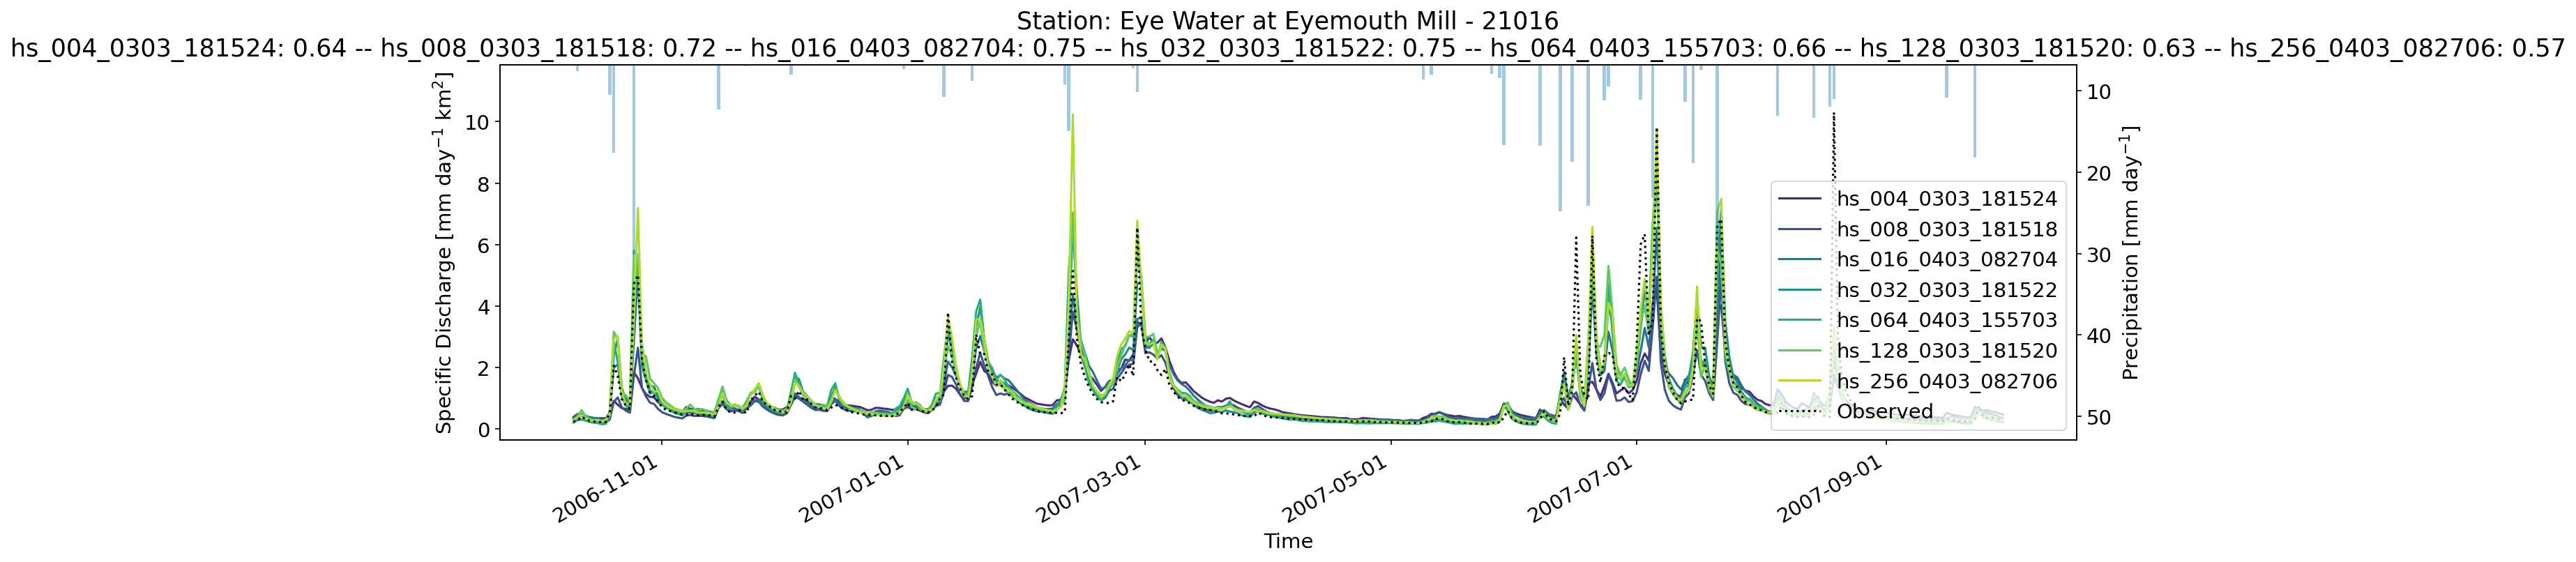

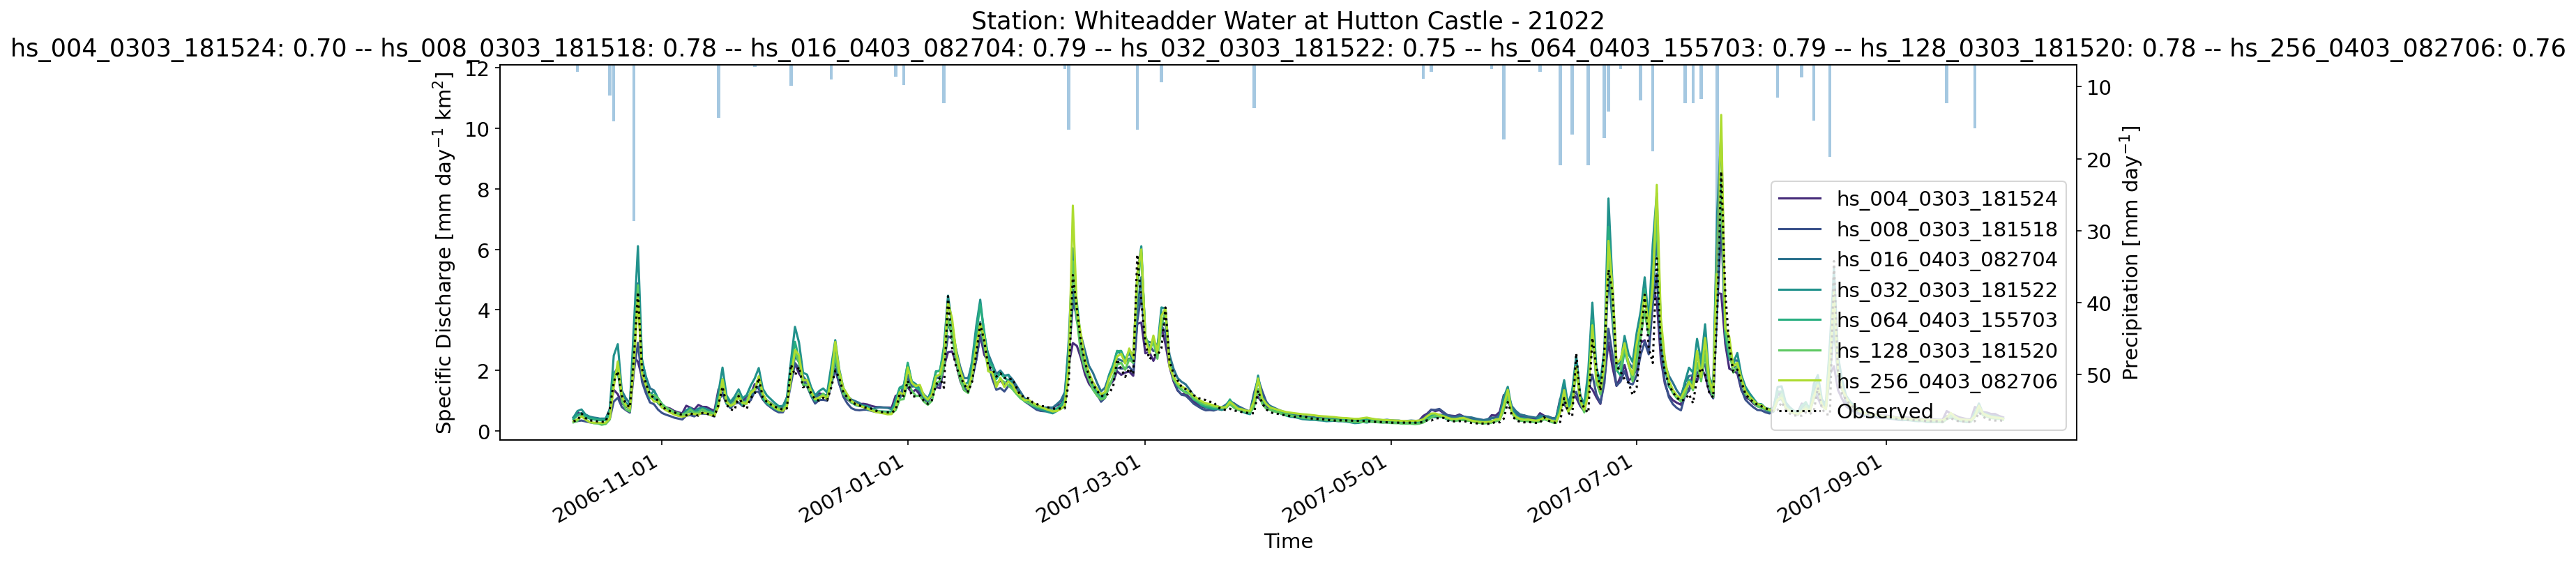

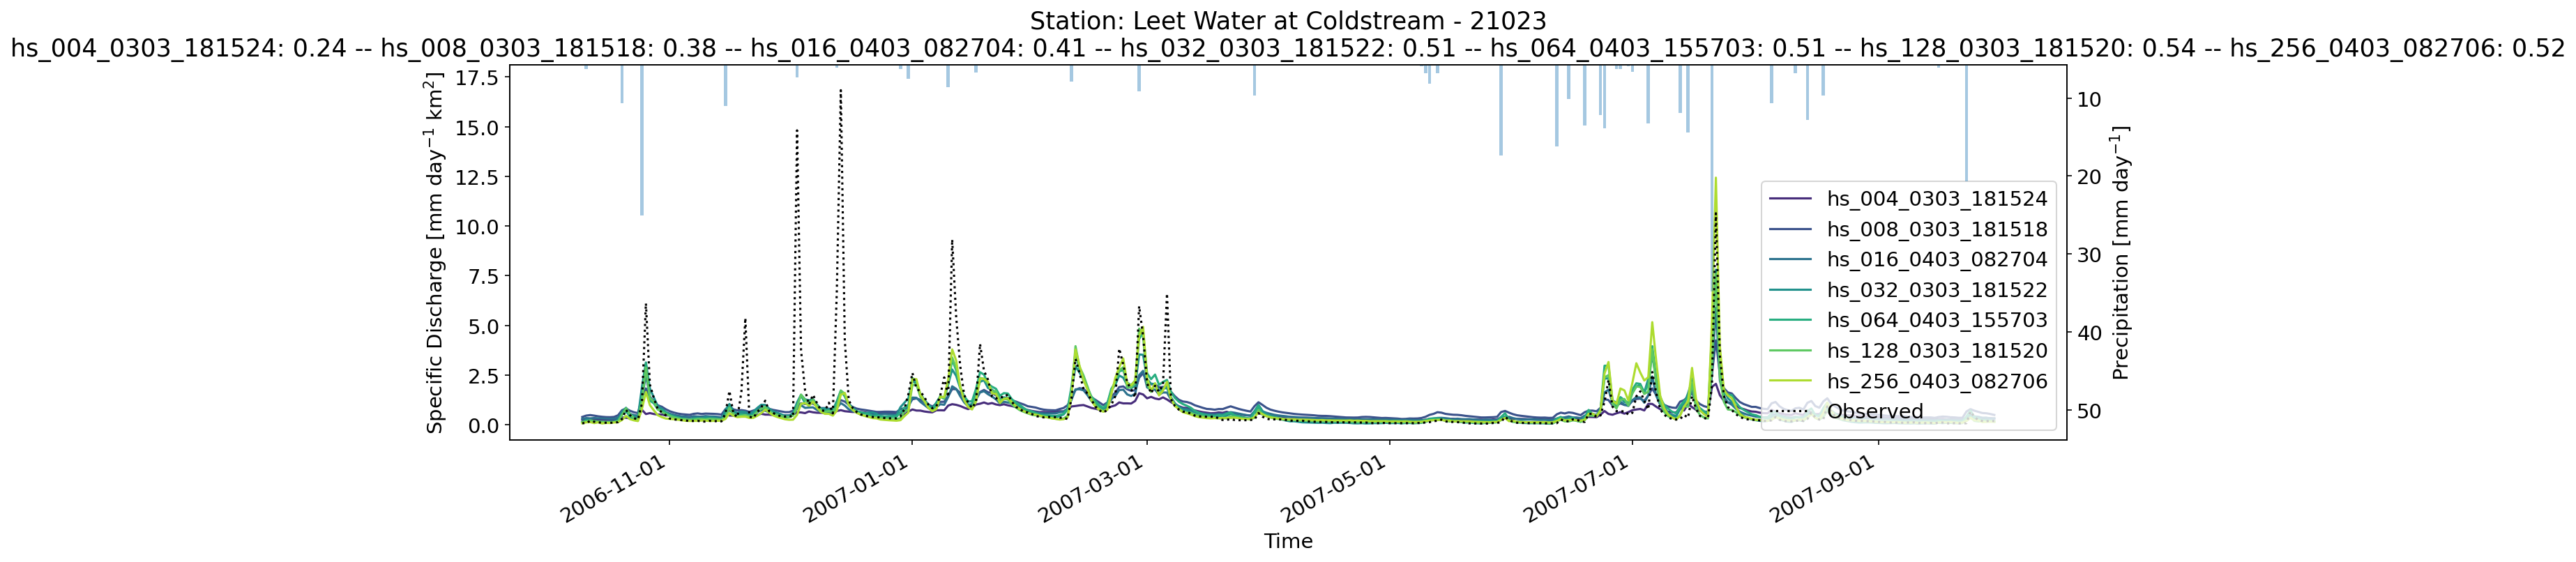

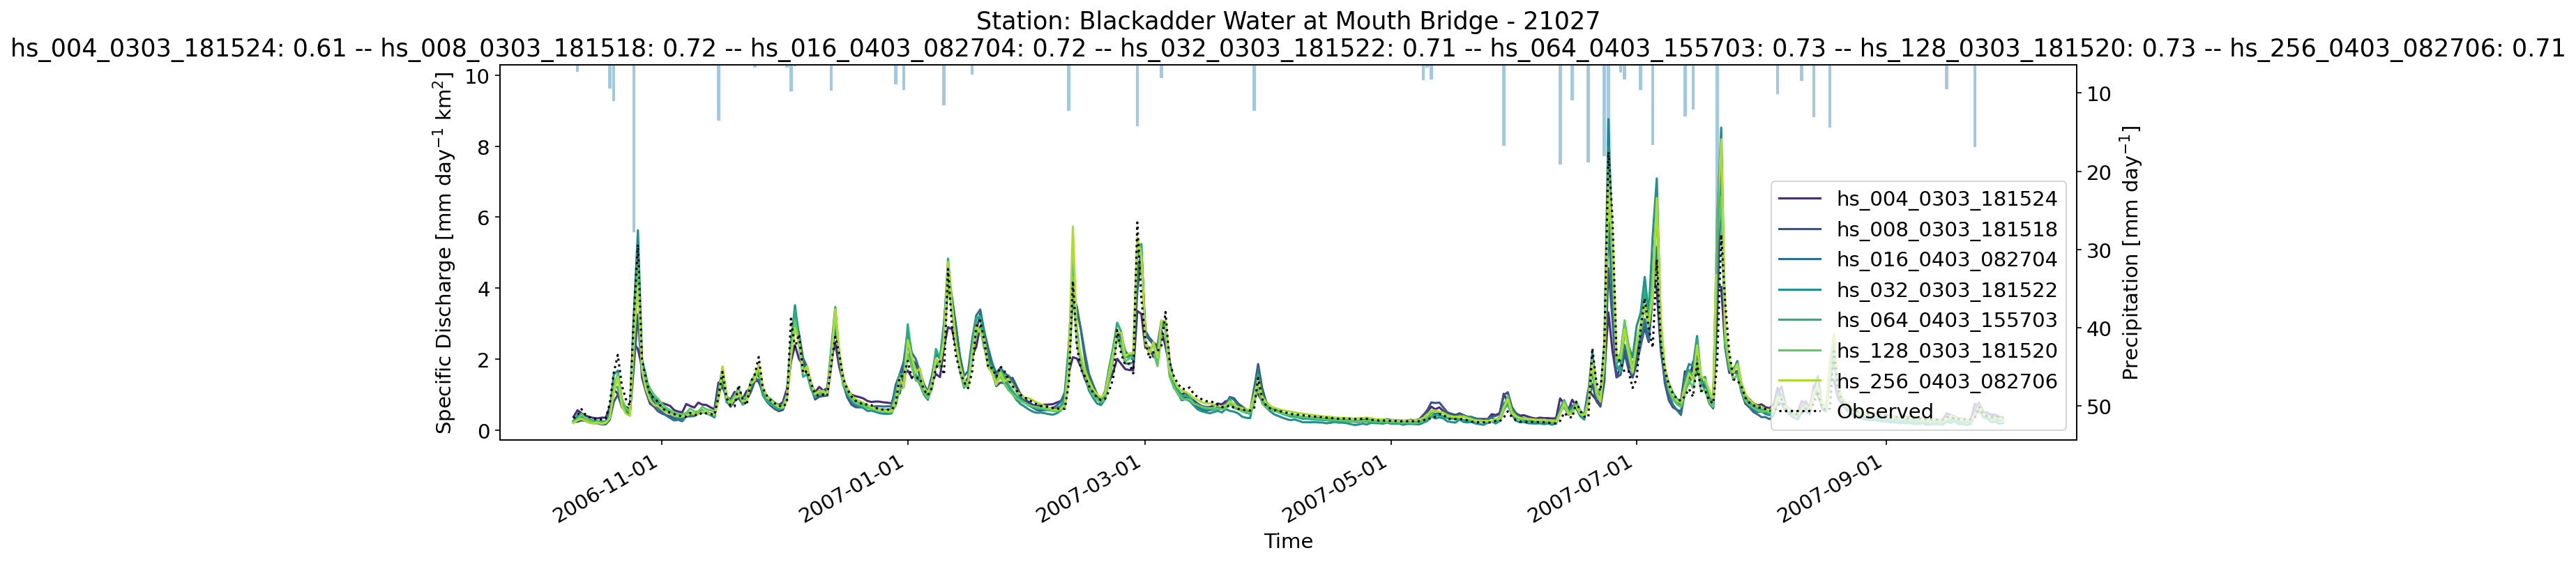

In [77]:
# Hydrographs
for sid in border_sids:
    plot_station_hg(all_preds, int(sid), scale=1.4)

# What is learned by the simplest `hs`=4 model?

In [113]:
from pandas.api.types import is_numeric_dtype
static_df = static.to_dataframe()
numeric_static = static[static_df.columns[[is_numeric_dtype(static_df[c]) for c in static_df.columns]]]

important_features = [
    # topography
    "dpsbar",
    "elev_mean",
    "elev_min",
    "elev_max",
    # Hydrologic Attributes
    "q_mean",
    "runoff_ratio",
    "slope_fdc",
    "baseflow_index",
    "Q5",
    "Q95",
    #  climatic indices
    "p_mean",
    "pet_mean",
    "aridity",
    "frac_snow",
    # landcover
    "dwood_perc",
    "ewood_perc",
    "grass_perc",
    "shrub_perc",
    "crop_perc",
    "urban_perc",
]
numeric_static = numeric_static[important_features]

In [129]:
out = {}
for data_var in numeric_static.data_vars:
    corr = float(xr.corr(metrics_xr["nse"].sel(hidden_size=4), numeric_static[data_var]))
    out[data_var] = corr
    
corrs_4 = pd.DataFrame(out, index=["correlation"])
corrs_4 = corrs_4.T.reset_index().rename({"index": "variable"}, axis=1).set_index("variable")
corrs_4 = corrs_4.reindex(corrs_4["correlation"].abs().sort_values(ascending=False).index)

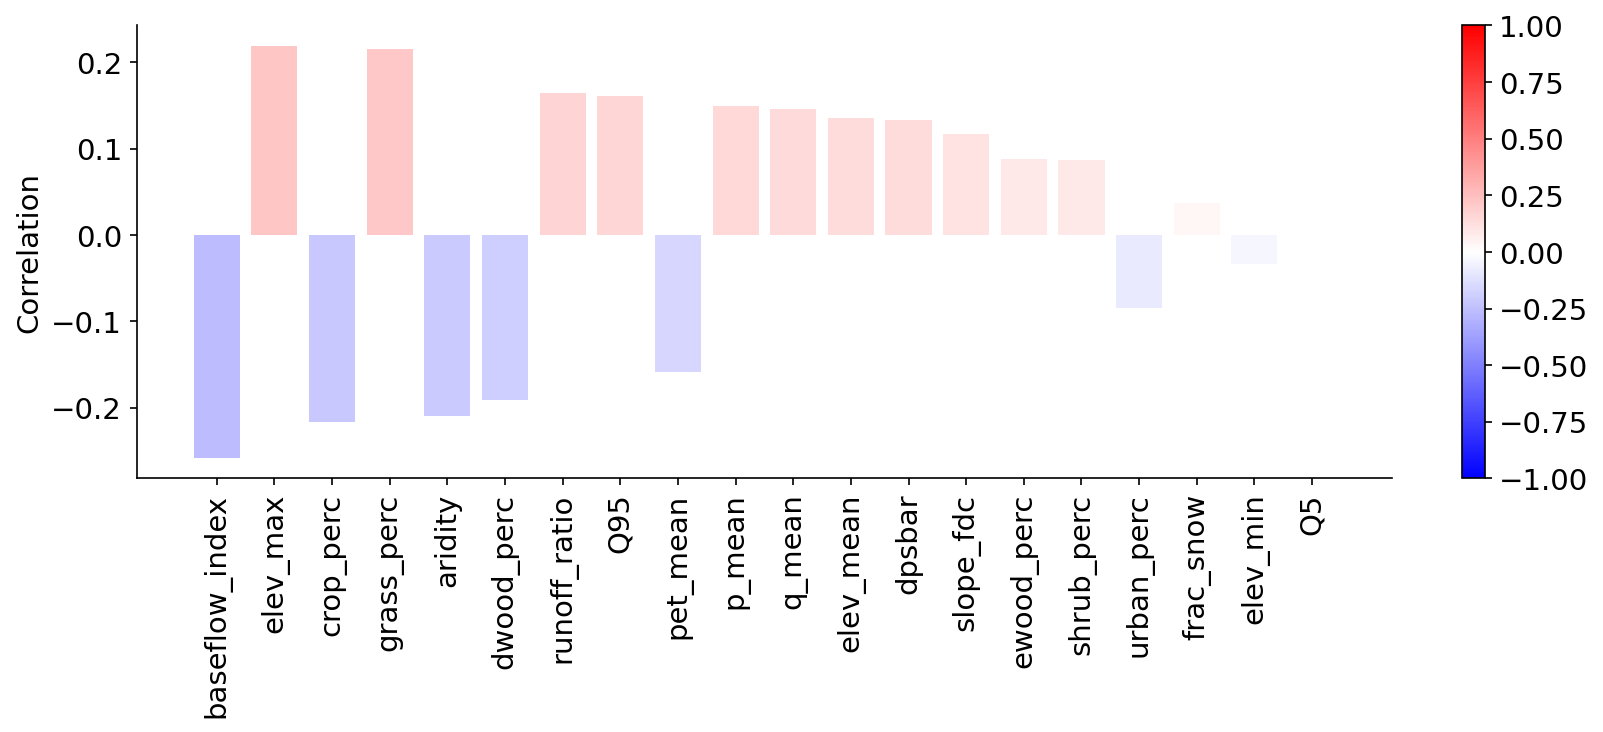

In [136]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib.cm import ScalarMappable

norm = TwoSlopeNorm(vcenter=0, vmin=-1, vmax=1)
cmap = plt.get_cmap('bwr')

x = corrs_4.index
y = corrs_4["correlation"]

f, ax = plt.subplots(figsize=(12, 4))
ax.bar(x=x, height=y, color=cmap(norm(y)))
plt.xticks(rotation='vertical');
ax.set_ylabel("Correlation")
f.colorbar(ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', ax=ax, fraction=0.05);
sns.despine()

In [137]:
from scripts.drafts.cell_state_extract import (load_config_file, load_ealstm, load_lstm, load_normalised_cs_data, normalize_xr_by_basin)

In [144]:
lstm_run_dirs = [d for d in run_dir.glob("hs_*")]
lstm_run_dirs = sorted(lstm_run_dirs)
lstm_configs = [load_config_file(d) for d in lstm_run_dirs]
lstm_models = [load_lstm(c) for c in lstm_configs]
lstm = lstm_models[0]

In [145]:
lstm

CudaLSTM(
  (lstm): LSTM(25, 4)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=4, out_features=1, bias=True)
    )
  )
)

# Is the data stationary in the South East / borderlands?
- yes

In [157]:
se_catchment_sids = se_stations = [41001, 41003, 41004, 41005, 41006, 41009, 41011, 41013, 41014,
            41016, 41019, 41020, 41022, 41025, 41027, 41029, 39010, 39011,
            39012, 39014, 39016, 40003, 40004, 40005, 40006, 40009, 40010,
            40011, 40016, 40017, 40018, 40020, 40021, 40033]
borderland_sids = [21016, 21022, 21023, 21027]

In [149]:
train_start_date = lstm_configs[0].train_start_date
train_end_date = lstm_configs[0].train_end_date
test_start_date = lstm_configs[0].test_start_date
test_end_date = lstm_configs[0].test_end_date

In [164]:
train_period = ds.sel(time=slice(train_start_date, train_end_date))
test_period = ds.sel(time=slice(test_start_date, test_end_date))

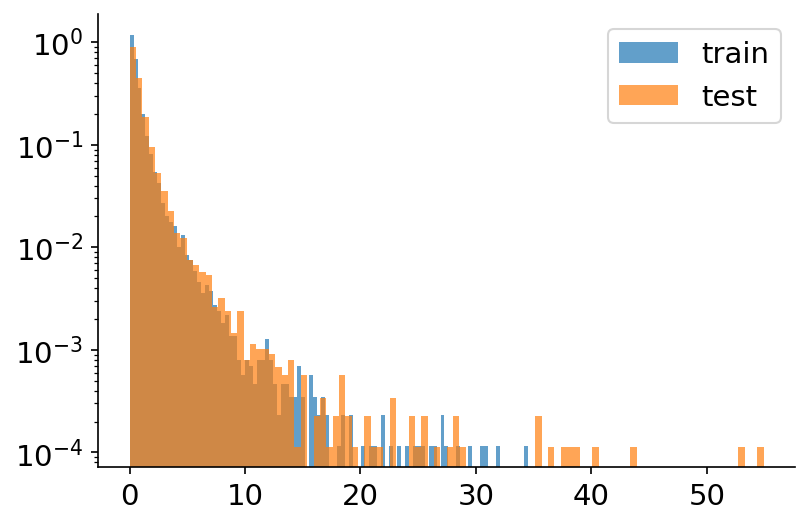

In [174]:
sids = borderland_sids
plt.hist(train_period.sel(station_id=sids).discharge_spec.values.flatten(), color="C0", alpha=0.7, bins=100, label="train", density=True, log=True)
plt.hist(test_period.sel(station_id=sids).discharge_spec.values.flatten(), color="C1", alpha=0.7, bins=100, label="test", density=True, log=True);
plt.legend()
sns.despine()

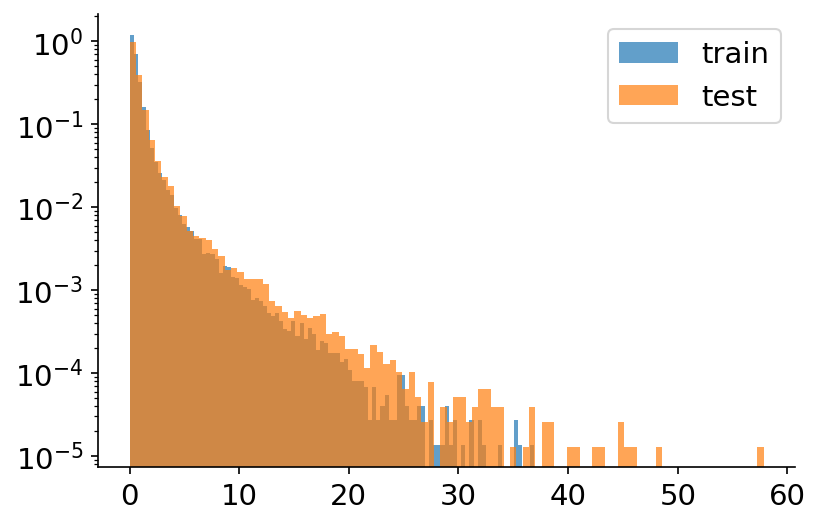

In [175]:
sids = se_catchment_sids
plt.hist(train_period.sel(station_id=sids).discharge_spec.values.flatten(), color="C0", alpha=0.7, bins=100, label="train", density=True, log=True)
plt.hist(test_period.sel(station_id=sids).discharge_spec.values.flatten(), color="C1", alpha=0.7, bins=100, label="test", density=True, log=True);
plt.legend()
sns.despine()

# how can we use runoff ratio as a proxy for catchment connectivity 
- perhaps calculating a monthly specific variable
- do we have enough data for this?

# How does the complexity of model performance vary over MONTHS ?

In [193]:
from scripts.drafts.calculate_error_scores import calculate_seasonal_errors, get_metric_dataframes_from_output_dict
from scripts.drafts.calculate_error_scores import convert_season_to_xr

In [196]:
seasonal_errors_path = (data_dir / "COMPLEXITY/seasonal_errors.pkl")

if not seasonal_errors_path.exists():
    seasonal_errors = calculate_seasonal_errors(all_preds)
    pickle.dump(seasonal_errors, seasonal_errors_path.open("wb"))
else:
    seasonal_errors = pickle.load(seasonal_errors_path.open("rb"))
    
seasonal_metrics = defaultdict(dict)
for season in ["DJF", "MAM", "JJA", "SON"]:
    seasonal_metrics[season] = get_metric_dataframes_from_output_dict(
        seasonal_errors[season]
    )
    
season_xr = convert_season_to_xr(seasonal_metrics)

In [197]:
season_xr

<xarray.Dataset>
Dimensions:                 (model: 7, season: 4, station_id: 667)
Coordinates:
  * season                  (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * station_id              (station_id) int64 10002 10003 1001 ... 96004 97002
  * model                   (model) object 'hs_004_0303_181524' ... 'hs_256_0...
Data variables:
    sqrt_variability_ratio  (season, station_id, model) float64 0.8356 ... 0....
    inv_variability_ratio   (season, station_id, model) float64 1.536 ... 0.7425
    variability_ratio       (season, station_id, model) float64 0.6724 ... 0....
    sqrt_correlation        (season, station_id, model) float64 0.8654 ... 0....
    inv_correlation         (season, station_id, model) float64 0.8223 ... 0.895
    sqrt_bias_ratio         (season, station_id, model) float64 0.8571 ... 0....
    inv_bias_ratio          (season, station_id, model) float64 1.379 ... 0.9881
    abs_pct_bias            (season, station_id, model) float64 26.8 ... 4.83
    correlation             (season, station_id, model) float64 0.8362 ... 0.931
    bias_error              (season, station_id, model) float64 -0.268 ... -0...
    bias_ratio              (season, station_id, model) float64 0.732 ... 0.9517
    std_error               (season, station_id, model) float64 -0.3276 ... -...
    mam30_ape               (season, station_id, model) float32 29.86 ... 1.285
    sqrt_kge                (season, station_id, model) float64 0.744 ... 0.9393
    log_nse                 (season, station_id, model) float64 0.3589 ... 0....
    inv_kge                 (season, station_id, model) float64 0.3203 ... 0....
    member                  (season, station_id, model) object 'hs_004_0303_1...
    pbias                   (season, station_id, model) float64 26.8 ... 4.83
    bias                    (season, station_id, model) float64 -26.8 ... -4.83
    mape                    (season, station_id, model) float64 28.34 ... 23.52
    rmse                    (season, station_id, model) float64 1.023 ... 1.18
    nse                     (season, station_id, model) float64 0.5169 ... 0....
    kge                     (season, station_id, model) float64 0.5461 ... 0....
    mse                     (season, station_id, model) float64 1.046 ... 1.393

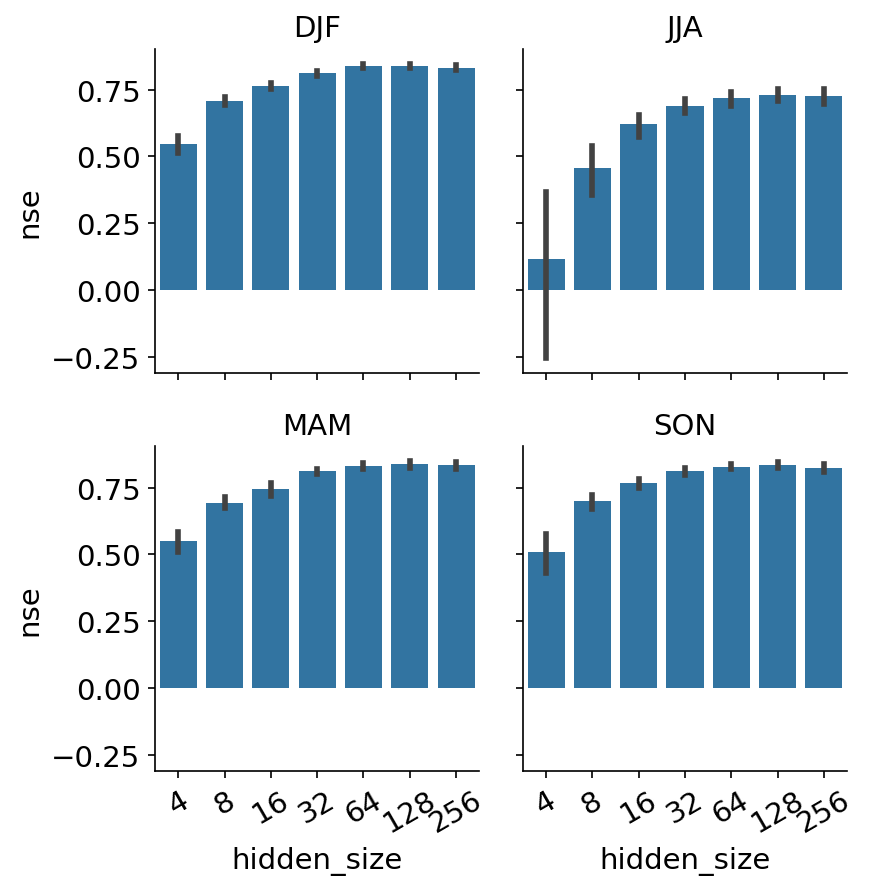

In [228]:
def plot_metric_per_season(metric: str):
    season_df = season_xr[metric].to_dataframe().reset_index()
    season_df["hidden_size"] = season_df["model"].str.extract(r'_(\d\d\d)_').astype(int)

    g = sns.FacetGrid(data=season_df, col="season", col_wrap=2)
    g.map(sns.barplot, "hidden_size", metric)
    g.set_titles(col_template="{col_name}")
    g.set_xticklabels(rotation=30)

    
plot_metric_per_season(metric="nse")

# TODO: Need to train them as ensembles to account for uncertainty in initalisation / random seeds

# Folium Plot

In [ ]:
assert False

In [56]:
import matplotlib
from matplotlib import cm


def _scale_values(values: np.ndarray) -> np.ndarray:
    amin = values.min()
    amax = values.max()
    numerator = (values - amin)
    denominator = (amax - amin)
    return (values - amin) / (amax - amin)


def assign_color_property(gdf: gpd.GeoDataFrame, column_str: str, cmap: str = "viridis_r", rescale_vmin_vmax: bool = False, vmin: Optional[float] = 0.7, vmax: Optional[float] = 1.0) -> gpd.GeoDataFrame:
    values = gdf[column_str]
    colormap = cm.get_cmap(cmap, len(values))
    
    if rescale_vmin_vmax:
        if vmin is None:
            vmin = np.quantile(values, 0.25)
        if vmax is None:
            vmax = np.quantile(values, 0.75)

        values[values < vmin] = vmin
        values[values > vmax] = vmax
    # values mapped to 0, 1 scale
    values = _scale_values(values)

    colors = [colormap(v) for v in values]
    hexes = [matplotlib.colors.rgb2hex(c) for c in colors]
    gdf["rgba"] = colors
    gdf["hex"] = hexes
    return gdf

In [57]:
metric_gdf = create_geospatial_data(all_metrics["nse"])
metric_gdf = metric_gdf.join(static[["gauge_name"]].to_dataframe())
metric_gdf.head()

metric_gdf = assign_color_property(metric_gdf, "hs_256_0403_082706", rescale_vmin_vmax=True)

In [64]:
# metric_gdf

In [62]:
import folium

def make_tooltip_str(row: pd.Series):
    from pandas.api.types import is_numeric_dtype
    from pprint import pformat
    
    tooltip_keys = [c for c in row.index if not c in ["geometry", "hex", "rgba"]]
    numeric_keys = np.array(tooltip_keys)[[isinstance(c, float) for c in row[tooltip_keys]]]
    row[numeric_keys] = [np.round(row[numeric_key], 2) for numeric_key in numeric_keys]
    return pformat(row[tooltip_keys].to_dict()).replace("{", "").replace("}", "").replace("\n", "<br>").replace("'", "")


def make_tooltip(row):
    tooltip_str = make_tooltip_str(row)
    return folium.Tooltip(
        tooltip_str,
        style=(''),
    )

In [63]:
# scale = 1.5
# width=300*scale, height=500*scale,
m = folium.Map(location=[55., -4.], zoom_start=6, tiles="cartodbpositron")

for ix, row in metric_gdf.iterrows():
    lat, lon = row["geometry"].y, row["geometry"].x
    folium.Circle(
        location=[lat, lon],
        radius=20,
        fill=True,
        color=row["hex"],
        tooltip=make_tooltip(row),
        popup=make_tooltip_str(row),
        #fill_opacity=0.7
    ).add_to(m)


folium.LayerControl().add_to(m)

m

array([21016, 21022, 21023, 21027])